In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from modules import network,mlp,contrastive_loss
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\4251183556.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 500) (8569, 1)


10  133     156     178  204  205  241  273       274  276  ...  \
0  1.302199  0.0  0.0000  0.0000  0.0  0.0  0.0  0.0  0.000000  0.0  ...   
1  1.351171  0.0  0.0000  0.0000  0.0  0.0  0.0  0.0  0.000000  0.0  ...   
2  0.000000  0.0  0.0000  0.0000  0.0  0.0  0.0  0.0  1.214231  0.0  ...   
3  0.000000  0.0  0.4175  0.4175  0.0  0.0  0.0  0.0  0.000000  0.0  ...   
4  0.000000  0.0  0.0000  0.0000  0.0  0.0  0.0  0.0  0.509045  0.0  ...   

   18662     18670     18684  18922     18923  19018    19048  19051  19158  \
0    0.0  0.000000  2.381123    0.0  0.000000    0.0  0.36896    0.0    0.0   
1    0.0  0.305824  2.919360    0.0  0.000000    0.0  0.00000    0.0    0.0   
2    0.0  0.000000  2.796676    0.0  0.464945    0.0  0.00000    0.0    0.0   
3    0.0  0.000000  1.531937    0.0  0.000000    0.0  0.00000    0.0    0.0   
4    0.0  0.000000  2.264689    0.0  0.000000    0.0  0.00000    0.0    0.0   

   20109  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0  

[5 rows x 500 columns]

In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scDataLoader = DataLoader(scDataset, shuffle=True, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

scGenDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

500
1024
1024
500
1024
1024


In [5]:
# initialize model
mlpp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlpp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

In [6]:
class StaticMemoryBank():

    def __init__(self,batch_size,x,y,dim):
        self.batch_size=batch_size
        self.dim=dim
        self.bank=hnswlib.Index(space='cosine',dim=dim)
        self.bank.init_index(max_elements=8569, ef_construction=100, M=16)
        self.bank.set_ef(100)
        self.bank.set_num_threads(4)
        self.bank.add_items(x)
        self.x_data=x
        self.y_data=y

    def generate_data(self,x_data,y_data):
        contrasts=np.zeros((self.batch_size,11,self.dim))
        # rare_list=[]
        for step,(x,y) in enumerate(zip(x_data,y_data)):
            if y in [8,10,11,13,14]:
                temp=np.tile(x, 10).reshape((10,500))
                temp=np.row_stack((temp,x))
                # rare_list.append(step)
                contrasts[step]=temp
            else:
                labels,distances=self.bank.knn_query(x,k=10)
                temp=x_ndarray[labels.tolist()]
                temp=np.row_stack((temp,x))
                contrasts[step]=temp
        
        # return contrasts,rare_list
        return contrasts

In [7]:
def train(instance_loss,cluster_loss,memory_bank,model):
    loss_epoch=0
    for step,(data,label) in enumerate(scDataLoader):
        optimizer.zero_grad()
        
        embedding_data=data.numpy().copy()
        data=data.to('cuda')
        label=label.numpy().copy()
        
        contrast_samples=torch.tensor(memory_bank.generate_data(embedding_data,label),dtype=torch.float32)
        iter_times=10
        for index in range(1,11):
            x_i=contrast_samples[:,0].clone().to('cuda')
            # print(f'sample shape:\n{x_i.shape}')
            
            x_j=contrast_samples[:,index].to('cuda')
            # print(f'data shape:\n{x_j.shape}')

            z_i,z_j,c_i,c_j=model(x_i,x_j)
            loss_instance=instance_loss(z_i,z_j)
            loss_cluster=cluster_loss(c_i,c_j)
            loss = loss_instance + loss_cluster
            # print(f'------ loss:\n{loss}')
            loss.backward()
            optimizer.step()
            loss_epoch+=loss.item()
        if step % 2 == 0:
                print(f"Step [{step}/{len(scDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
            
    return loss_epoch/iter_times

In [8]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 1000 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

In [9]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scDataLoader, model, device)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    return nmi, ari, f, acc

In [10]:
loss_device=torch.device('cuda')
instance_loss=contrastive_loss.InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=contrastive_loss.ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
aris=[]
nmis=[]
fs=[]

memory_bank=StaticMemoryBank(batch_size=args.batch_size,x=x_ndarray,y=y_ndarray,dim=args.num_genes)

for epoch in range(args.start_epoch, args.epochs+1):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(instance_loss,cluster_loss,memory_bank,model=model)
    losses.append(loss_epoch/len(scDataLoader))
    if epoch % 1 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    aris.append(ari)
    nmis.append(nmi)
    fs.append(f)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 7.604371070861816	 loss_cluster: 3.2987663745880127
Step [2/8]	 loss_instance: 7.471243381500244	 loss_cluster: 3.298388957977295
Step [4/8]	 loss_instance: 7.1949143409729	 loss_cluster: 3.2974119186401367
Step [6/8]	 loss_instance: 6.979643821716309	 loss_cluster: 3.294613838195801

Epoch [1/200]	 Loss: 10.610846364498139 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5540 ARI = 0.3640 F = 0.6048 ACC = 0.5176



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.809035301208496	 loss_cluster: 3.2881691455841064
Step [2/8]	 loss_instance: 6.669760704040527	 loss_cluster: 3.2723917961120605
Step [4/8]	 loss_instance: 6.4222941398620605	 loss_cluster: 3.236335039138794
Step [6/8]	 loss_instance: 6.390140533447266	 loss_cluster: 3.1821324825286865

Epoch [2/200]	 Loss: 9.898446989059448 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.4598 ARI = 0.2673 F = 0.4323 ACC = 0.4944



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.308427810668945	 loss_cluster: 3.090564489364624
Step [2/8]	 loss_instance: 6.284121990203857	 loss_cluster: 2.9870269298553467
Step [4/8]	 loss_instance: 6.255553245544434	 loss_cluster: 2.917675495147705
Step [6/8]	 loss_instance: 6.2570319175720215	 loss_cluster: 2.865964412689209

Epoch [3/200]	 Loss: 9.365682756900787 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.5496 ARI = 0.4480 F = 0.5463 ACC = 0.5718



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.230261325836182	 loss_cluster: 2.80971622467041
Step [2/8]	 loss_instance: 6.223210334777832	 loss_cluster: 2.768115997314453
Step [4/8]	 loss_instance: 6.209203720092773	 loss_cluster: 2.718275308609009
Step [6/8]	 loss_instance: 6.196866512298584	 loss_cluster: 2.6684234142303467

Epoch [4/200]	 Loss: 9.064554214477539 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6134 ARI = 0.4218 F = 0.5241 ACC = 0.5830



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.184845924377441	 loss_cluster: 2.6045026779174805
Step [2/8]	 loss_instance: 6.138968467712402	 loss_cluster: 2.572127342224121
Step [4/8]	 loss_instance: 6.134397029876709	 loss_cluster: 2.5415802001953125
Step [6/8]	 loss_instance: 6.138749599456787	 loss_cluster: 2.5116329193115234

Epoch [5/200]	 Loss: 8.832191276550294 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6636 ARI = 0.5352 F = 0.6202 ACC = 0.6155



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.112137317657471	 loss_cluster: 2.4689109325408936
Step [2/8]	 loss_instance: 6.117866039276123	 loss_cluster: 2.449174404144287
Step [4/8]	 loss_instance: 6.073126792907715	 loss_cluster: 2.3838729858398438
Step [6/8]	 loss_instance: 6.089101314544678	 loss_cluster: 2.3499786853790283

Epoch [6/200]	 Loss: 8.650108969211578 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6609 ARI = 0.4837 F = 0.5761 ACC = 0.5175



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.083446979522705	 loss_cluster: 2.3425190448760986
Step [2/8]	 loss_instance: 6.066771030426025	 loss_cluster: 2.2707629203796387
Step [4/8]	 loss_instance: 6.101510047912598	 loss_cluster: 2.2397146224975586
Step [6/8]	 loss_instance: 6.07187032699585	 loss_cluster: 2.2320077419281006

Epoch [7/200]	 Loss: 8.507222104072572 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6744 ARI = 0.5795 F = 0.6576 ACC = 0.6554



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.091279983520508	 loss_cluster: 2.1905789375305176
Step [2/8]	 loss_instance: 6.064985752105713	 loss_cluster: 2.1670048236846924
Step [4/8]	 loss_instance: 6.070193767547607	 loss_cluster: 2.1620218753814697
Step [6/8]	 loss_instance: 6.0513834953308105	 loss_cluster: 2.1486408710479736

Epoch [8/200]	 Loss: 8.401204943656921 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6827 ARI = 0.5518 F = 0.6378 ACC = 0.6125



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.056098937988281	 loss_cluster: 2.1079933643341064
Step [2/8]	 loss_instance: 6.046276092529297	 loss_cluster: 2.082547426223755
Step [4/8]	 loss_instance: 6.0413312911987305	 loss_cluster: 2.051086187362671
Step [6/8]	 loss_instance: 6.0636677742004395	 loss_cluster: 2.063339948654175

Epoch [9/200]	 Loss: 8.304641783237457 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6692 ARI = 0.5154 F = 0.6091 ACC = 0.5522



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.043776035308838	 loss_cluster: 2.0420827865600586
Step [2/8]	 loss_instance: 6.0581231117248535	 loss_cluster: 2.0341200828552246
Step [4/8]	 loss_instance: 6.024953365325928	 loss_cluster: 1.9750351905822754
Step [6/8]	 loss_instance: 6.041126728057861	 loss_cluster: 1.9792605638504028

Epoch [10/200]	 Loss: 8.242458015680313 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6576 ARI = 0.4960 F = 0.5936 ACC = 0.5311



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.026323318481445	 loss_cluster: 1.9464819431304932
Step [2/8]	 loss_instance: 6.02902364730835	 loss_cluster: 1.966130018234253
Step [4/8]	 loss_instance: 6.041168212890625	 loss_cluster: 1.9790087938308716
Step [6/8]	 loss_instance: 6.041898250579834	 loss_cluster: 1.9420660734176636

Epoch [11/200]	 Loss: 8.196887409687042 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6555 ARI = 0.4656 F = 0.5695 ACC = 0.5060



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.033840656280518	 loss_cluster: 1.9006805419921875
Step [2/8]	 loss_instance: 6.046588897705078	 loss_cluster: 1.8898773193359375
Step [4/8]	 loss_instance: 6.0251617431640625	 loss_cluster: 1.8783818483352661
Step [6/8]	 loss_instance: 6.029543399810791	 loss_cluster: 1.8623051643371582

Epoch [12/200]	 Loss: 8.126001143455506 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6565 ARI = 0.4264 F = 0.5395 ACC = 0.4614



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.026284217834473	 loss_cluster: 1.8566579818725586
Step [2/8]	 loss_instance: 6.015346050262451	 loss_cluster: 1.8413816690444946
Step [4/8]	 loss_instance: 6.036518573760986	 loss_cluster: 1.8266961574554443
Step [6/8]	 loss_instance: 6.0272746086120605	 loss_cluster: 1.823593258857727

Epoch [13/200]	 Loss: 8.087125885486603 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6613 ARI = 0.4137 F = 0.5303 ACC = 0.4244



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 6.037134647369385	 loss_cluster: 1.8102099895477295
Step [2/8]	 loss_instance: 6.0334248542785645	 loss_cluster: 1.8123984336853027
Step [4/8]	 loss_instance: 6.019715309143066	 loss_cluster: 1.781535029411316
Step [6/8]	 loss_instance: 6.002840042114258	 loss_cluster: 1.7574515342712402

Epoch [14/200]	 Loss: 8.032608604431152 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6741 ARI = 0.4481 F = 0.5581 ACC = 0.4946



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.999720573425293	 loss_cluster: 1.7353060245513916
Step [2/8]	 loss_instance: 6.004605293273926	 loss_cluster: 1.7439936399459839
Step [4/8]	 loss_instance: 6.0088348388671875	 loss_cluster: 1.7587254047393799
Step [6/8]	 loss_instance: 6.012020587921143	 loss_cluster: 1.7513004541397095

Epoch [15/200]	 Loss: 7.9875477194786075 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6714 ARI = 0.4293 F = 0.5437 ACC = 0.4753



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.997440814971924	 loss_cluster: 1.720610499382019
Step [2/8]	 loss_instance: 5.9963555335998535	 loss_cluster: 1.7153955698013306
Step [4/8]	 loss_instance: 5.986947536468506	 loss_cluster: 1.6942682266235352
Step [6/8]	 loss_instance: 5.985263347625732	 loss_cluster: 1.6847776174545288

Epoch [16/200]	 Loss: 7.941320151090622 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6698 ARI = 0.4217 F = 0.5375 ACC = 0.4381



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.983269691467285	 loss_cluster: 1.6971265077590942
Step [2/8]	 loss_instance: 5.987900733947754	 loss_cluster: 1.6915843486785889
Step [4/8]	 loss_instance: 5.976991176605225	 loss_cluster: 1.6894311904907227
Step [6/8]	 loss_instance: 5.989263534545898	 loss_cluster: 1.672824501991272

Epoch [17/200]	 Loss: 7.912320309877396 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6711 ARI = 0.4211 F = 0.5366 ACC = 0.4565



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.978658676147461	 loss_cluster: 1.685488224029541
Step [2/8]	 loss_instance: 5.967932224273682	 loss_cluster: 1.678141713142395
Step [4/8]	 loss_instance: 5.976506233215332	 loss_cluster: 1.6802711486816406
Step [6/8]	 loss_instance: 5.9690656661987305	 loss_cluster: 1.6678656339645386

Epoch [18/200]	 Loss: 7.90214319229126 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6754 ARI = 0.4196 F = 0.5363 ACC = 0.4453



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.973609447479248	 loss_cluster: 1.6645539999008179
Step [2/8]	 loss_instance: 5.97427225112915	 loss_cluster: 1.6629486083984375
Step [4/8]	 loss_instance: 5.970513343811035	 loss_cluster: 1.6652944087982178
Step [6/8]	 loss_instance: 5.969357967376709	 loss_cluster: 1.6637117862701416

Epoch [19/200]	 Loss: 7.88299793601036 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6802 ARI = 0.4211 F = 0.5366 ACC = 0.4434



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.969432353973389	 loss_cluster: 1.6658047437667847
Step [2/8]	 loss_instance: 5.9640045166015625	 loss_cluster: 1.6651710271835327
Step [4/8]	 loss_instance: 5.948576927185059	 loss_cluster: 1.6437450647354126
Step [6/8]	 loss_instance: 5.955881595611572	 loss_cluster: 1.6610788106918335

Epoch [20/200]	 Loss: 7.887649244070053 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6868 ARI = 0.4307 F = 0.5454 ACC = 0.4547



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.97294807434082	 loss_cluster: 1.6693556308746338
Step [2/8]	 loss_instance: 5.967038154602051	 loss_cluster: 1.6700568199157715
Step [4/8]	 loss_instance: 5.967600345611572	 loss_cluster: 1.6639094352722168
Step [6/8]	 loss_instance: 5.955934524536133	 loss_cluster: 1.6555191278457642

Epoch [21/200]	 Loss: 7.868685322999954 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6855 ARI = 0.4228 F = 0.5394 ACC = 0.4519



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.950813293457031	 loss_cluster: 1.6389015913009644
Step [2/8]	 loss_instance: 5.95290470123291	 loss_cluster: 1.638800024986267
Step [4/8]	 loss_instance: 5.946390628814697	 loss_cluster: 1.6297329664230347
Step [6/8]	 loss_instance: 5.95796012878418	 loss_cluster: 1.6449997425079346

Epoch [22/200]	 Loss: 7.842965584993363 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6829 ARI = 0.4220 F = 0.5384 ACC = 0.4456



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.963074207305908	 loss_cluster: 1.6608543395996094
Step [2/8]	 loss_instance: 5.951822280883789	 loss_cluster: 1.6301215887069702
Step [4/8]	 loss_instance: 5.937585353851318	 loss_cluster: 1.6291714906692505
Step [6/8]	 loss_instance: 5.950812339782715	 loss_cluster: 1.6503254175186157

Epoch [23/200]	 Loss: 7.842174518108368 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6813 ARI = 0.4189 F = 0.5366 ACC = 0.4347



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.950436115264893	 loss_cluster: 1.6355524063110352
Step [2/8]	 loss_instance: 5.951236724853516	 loss_cluster: 1.6407912969589233
Step [4/8]	 loss_instance: 5.951911449432373	 loss_cluster: 1.6385434865951538
Step [6/8]	 loss_instance: 5.939275741577148	 loss_cluster: 1.627714991569519

Epoch [24/200]	 Loss: 7.838304096460343 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6892 ARI = 0.4283 F = 0.5443 ACC = 0.4528



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.943140506744385	 loss_cluster: 1.6306902170181274
Step [2/8]	 loss_instance: 5.945096015930176	 loss_cluster: 1.648837685585022
Step [4/8]	 loss_instance: 5.940064907073975	 loss_cluster: 1.629479169845581
Step [6/8]	 loss_instance: 5.938488960266113	 loss_cluster: 1.6317342519760132

Epoch [25/200]	 Loss: 7.835252827405929 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6799 ARI = 0.4197 F = 0.5363 ACC = 0.4412



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.937049865722656	 loss_cluster: 1.6345410346984863
Step [2/8]	 loss_instance: 5.939454555511475	 loss_cluster: 1.627638816833496
Step [4/8]	 loss_instance: 5.939029216766357	 loss_cluster: 1.6216614246368408
Step [6/8]	 loss_instance: 5.938878536224365	 loss_cluster: 1.6265485286712646

Epoch [26/200]	 Loss: 7.819020980596543 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6884 ARI = 0.4312 F = 0.5463 ACC = 0.4618



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.943295478820801	 loss_cluster: 1.6246346235275269
Step [2/8]	 loss_instance: 5.940797805786133	 loss_cluster: 1.6291680335998535
Step [4/8]	 loss_instance: 5.933955192565918	 loss_cluster: 1.6291520595550537
Step [6/8]	 loss_instance: 5.937312602996826	 loss_cluster: 1.6293340921401978

Epoch [27/200]	 Loss: 7.818695288896561 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6809 ARI = 0.4185 F = 0.5358 ACC = 0.4365



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.932742595672607	 loss_cluster: 1.6230391263961792
Step [2/8]	 loss_instance: 5.9352192878723145	 loss_cluster: 1.6259406805038452
Step [4/8]	 loss_instance: 5.931196212768555	 loss_cluster: 1.6223713159561157
Step [6/8]	 loss_instance: 5.929154872894287	 loss_cluster: 1.6090337038040161

Epoch [28/200]	 Loss: 7.810493665933609 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6935 ARI = 0.4283 F = 0.5443 ACC = 0.4457



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.934412479400635	 loss_cluster: 1.6326504945755005
Step [2/8]	 loss_instance: 5.935709476470947	 loss_cluster: 1.6283795833587646
Step [4/8]	 loss_instance: 5.946474552154541	 loss_cluster: 1.636845350265503
Step [6/8]	 loss_instance: 5.934775352478027	 loss_cluster: 1.6267820596694946

Epoch [29/200]	 Loss: 7.816752648353576 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6864 ARI = 0.4205 F = 0.5376 ACC = 0.4432



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.942645072937012	 loss_cluster: 1.6206222772598267
Step [2/8]	 loss_instance: 5.94324254989624	 loss_cluster: 1.6218162775039673
Step [4/8]	 loss_instance: 5.938814163208008	 loss_cluster: 1.6165739297866821
Step [6/8]	 loss_instance: 5.938270092010498	 loss_cluster: 1.6163018941879272

Epoch [30/200]	 Loss: 7.802075380086899 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6884 ARI = 0.4208 F = 0.5387 ACC = 0.4296



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.947327613830566	 loss_cluster: 1.6225974559783936
Step [2/8]	 loss_instance: 5.9356513023376465	 loss_cluster: 1.630491852760315
Step [4/8]	 loss_instance: 5.947871208190918	 loss_cluster: 1.627400279045105
Step [6/8]	 loss_instance: 5.928732395172119	 loss_cluster: 1.6114214658737183

Epoch [31/200]	 Loss: 7.804577511548996 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6922 ARI = 0.4278 F = 0.5443 ACC = 0.4436



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9171223640441895	 loss_cluster: 1.5998456478118896
Step [2/8]	 loss_instance: 5.93109130859375	 loss_cluster: 1.6100883483886719
Step [4/8]	 loss_instance: 5.935152053833008	 loss_cluster: 1.628555417060852
Step [6/8]	 loss_instance: 5.93310022354126	 loss_cluster: 1.6119781732559204

Epoch [32/200]	 Loss: 7.793114548921585 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6883 ARI = 0.4212 F = 0.5386 ACC = 0.4348



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.929675579071045	 loss_cluster: 1.6222891807556152
Step [2/8]	 loss_instance: 5.935569763183594	 loss_cluster: 1.6148450374603271
Step [4/8]	 loss_instance: 5.926496982574463	 loss_cluster: 1.6210496425628662
Step [6/8]	 loss_instance: 5.919848442077637	 loss_cluster: 1.6042068004608154

Epoch [33/200]	 Loss: 7.7855772793293 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6878 ARI = 0.4229 F = 0.5400 ACC = 0.4404



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.932282447814941	 loss_cluster: 1.6150130033493042
Step [2/8]	 loss_instance: 5.925003528594971	 loss_cluster: 1.6125152111053467
Step [4/8]	 loss_instance: 5.917478084564209	 loss_cluster: 1.6154611110687256
Step [6/8]	 loss_instance: 5.923665523529053	 loss_cluster: 1.6157300472259521

Epoch [34/200]	 Loss: 7.781345820426941 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6867 ARI = 0.4206 F = 0.5381 ACC = 0.4451



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.919028282165527	 loss_cluster: 1.6059321165084839
Step [2/8]	 loss_instance: 5.920478343963623	 loss_cluster: 1.6067136526107788
Step [4/8]	 loss_instance: 5.917281150817871	 loss_cluster: 1.6086663007736206
Step [6/8]	 loss_instance: 5.91224479675293	 loss_cluster: 1.6000862121582031

Epoch [35/200]	 Loss: 7.776791054010391 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6919 ARI = 0.4231 F = 0.5404 ACC = 0.4442



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9216508865356445	 loss_cluster: 1.602317214012146
Step [2/8]	 loss_instance: 5.916851997375488	 loss_cluster: 1.6144455671310425
Step [4/8]	 loss_instance: 5.914154529571533	 loss_cluster: 1.6113327741622925
Step [6/8]	 loss_instance: 5.912785053253174	 loss_cluster: 1.5995745658874512

Epoch [36/200]	 Loss: 7.7668836414813995 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6899 ARI = 0.4238 F = 0.5414 ACC = 0.4326



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.917777061462402	 loss_cluster: 1.6021257638931274
Step [2/8]	 loss_instance: 5.923282146453857	 loss_cluster: 1.6113442182540894
Step [4/8]	 loss_instance: 5.930830478668213	 loss_cluster: 1.6271898746490479
Step [6/8]	 loss_instance: 5.927297115325928	 loss_cluster: 1.618403434753418

Epoch [37/200]	 Loss: 7.773896443843841 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6919 ARI = 0.4328 F = 0.5481 ACC = 0.4556



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.920815467834473	 loss_cluster: 1.5990134477615356
Step [2/8]	 loss_instance: 5.929474353790283	 loss_cluster: 1.6087857484817505
Step [4/8]	 loss_instance: 5.923260688781738	 loss_cluster: 1.6158279180526733
Step [6/8]	 loss_instance: 5.9234113693237305	 loss_cluster: 1.6035358905792236

Epoch [38/200]	 Loss: 7.78212023973465 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6895 ARI = 0.4328 F = 0.5477 ACC = 0.4702



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.918530464172363	 loss_cluster: 1.61491858959198
Step [2/8]	 loss_instance: 5.912097930908203	 loss_cluster: 1.5984262228012085
Step [4/8]	 loss_instance: 5.908227920532227	 loss_cluster: 1.606823205947876
Step [6/8]	 loss_instance: 5.917423248291016	 loss_cluster: 1.623047113418579

Epoch [39/200]	 Loss: 7.777481031417847 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6784 ARI = 0.4128 F = 0.5319 ACC = 0.4325



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.924702167510986	 loss_cluster: 1.6186408996582031
Step [2/8]	 loss_instance: 5.920079708099365	 loss_cluster: 1.6090292930603027
Step [4/8]	 loss_instance: 5.917098045349121	 loss_cluster: 1.601792812347412
Step [6/8]	 loss_instance: 5.919485569000244	 loss_cluster: 1.6064598560333252

Epoch [40/200]	 Loss: 7.761721462011337 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6844 ARI = 0.4144 F = 0.5329 ACC = 0.4379



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9094672203063965	 loss_cluster: 1.602374792098999
Step [2/8]	 loss_instance: 5.9154276847839355	 loss_cluster: 1.6054184436798096
Step [4/8]	 loss_instance: 5.913028717041016	 loss_cluster: 1.6020742654800415
Step [6/8]	 loss_instance: 5.9222092628479	 loss_cluster: 1.6049985885620117

Epoch [41/200]	 Loss: 7.7572059571743015 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6860 ARI = 0.4153 F = 0.5340 ACC = 0.4315



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.915937423706055	 loss_cluster: 1.6079214811325073
Step [2/8]	 loss_instance: 5.919285297393799	 loss_cluster: 1.6003153324127197
Step [4/8]	 loss_instance: 5.915550708770752	 loss_cluster: 1.5948315858840942
Step [6/8]	 loss_instance: 5.913872241973877	 loss_cluster: 1.6003042459487915

Epoch [42/200]	 Loss: 7.7535851240158085 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6897 ARI = 0.4191 F = 0.5379 ACC = 0.4492



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.908585071563721	 loss_cluster: 1.599542498588562
Step [2/8]	 loss_instance: 5.914071559906006	 loss_cluster: 1.609727382659912
Step [4/8]	 loss_instance: 5.904638290405273	 loss_cluster: 1.5984903573989868
Step [6/8]	 loss_instance: 5.914032459259033	 loss_cluster: 1.5963834524154663

Epoch [43/200]	 Loss: 7.750821948051453 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6899 ARI = 0.4227 F = 0.5405 ACC = 0.4432



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.914167881011963	 loss_cluster: 1.6000601053237915
Step [2/8]	 loss_instance: 5.908210754394531	 loss_cluster: 1.6024049520492554
Step [4/8]	 loss_instance: 5.908237934112549	 loss_cluster: 1.5999122858047485
Step [6/8]	 loss_instance: 5.9085373878479	 loss_cluster: 1.6001155376434326

Epoch [44/200]	 Loss: 7.749521642923355 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6894 ARI = 0.4268 F = 0.5438 ACC = 0.4690



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.908764362335205	 loss_cluster: 1.5910601615905762
Step [2/8]	 loss_instance: 5.912010669708252	 loss_cluster: 1.606529951095581
Step [4/8]	 loss_instance: 5.931134223937988	 loss_cluster: 1.6243482828140259
Step [6/8]	 loss_instance: 5.916868209838867	 loss_cluster: 1.60794997215271

Epoch [45/200]	 Loss: 7.759012573957444 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6850 ARI = 0.4187 F = 0.5362 ACC = 0.4377



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.90579891204834	 loss_cluster: 1.5914762020111084
Step [2/8]	 loss_instance: 5.919408321380615	 loss_cluster: 1.6063882112503052
Step [4/8]	 loss_instance: 5.9050397872924805	 loss_cluster: 1.6017688512802124
Step [6/8]	 loss_instance: 5.90753698348999	 loss_cluster: 1.6071687936782837

Epoch [46/200]	 Loss: 7.739938867092133 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6791 ARI = 0.4156 F = 0.5345 ACC = 0.4508



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.906545639038086	 loss_cluster: 1.602060079574585
Step [2/8]	 loss_instance: 5.900338172912598	 loss_cluster: 1.5994271039962769
Step [4/8]	 loss_instance: 5.916255950927734	 loss_cluster: 1.6054295301437378
Step [6/8]	 loss_instance: 5.905881881713867	 loss_cluster: 1.60454523563385

Epoch [47/200]	 Loss: 7.749473148584366 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6866 ARI = 0.4189 F = 0.5379 ACC = 0.4523



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.91579532623291	 loss_cluster: 1.6102710962295532
Step [2/8]	 loss_instance: 5.915019989013672	 loss_cluster: 1.6010385751724243
Step [4/8]	 loss_instance: 5.91273832321167	 loss_cluster: 1.6104235649108887
Step [6/8]	 loss_instance: 5.909171104431152	 loss_cluster: 1.59257972240448

Epoch [48/200]	 Loss: 7.749952578544617 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6957 ARI = 0.4276 F = 0.5455 ACC = 0.4700



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8983259201049805	 loss_cluster: 1.6091550588607788
Step [2/8]	 loss_instance: 5.902200698852539	 loss_cluster: 1.5946420431137085
Step [4/8]	 loss_instance: 5.8982038497924805	 loss_cluster: 1.5930687189102173
Step [6/8]	 loss_instance: 5.90513801574707	 loss_cluster: 1.6082466840744019

Epoch [49/200]	 Loss: 7.7393494009971615 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6922 ARI = 0.4238 F = 0.5425 ACC = 0.4611



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.907391548156738	 loss_cluster: 1.595076084136963
Step [2/8]	 loss_instance: 5.896359443664551	 loss_cluster: 1.5992432832717896
Step [4/8]	 loss_instance: 5.9048357009887695	 loss_cluster: 1.6143288612365723
Step [6/8]	 loss_instance: 5.9042158126831055	 loss_cluster: 1.6013518571853638

Epoch [50/200]	 Loss: 7.741838592290878 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6775 ARI = 0.4167 F = 0.5340 ACC = 0.4517



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903887748718262	 loss_cluster: 1.604899287223816
Step [2/8]	 loss_instance: 5.905047416687012	 loss_cluster: 1.6017651557922363
Step [4/8]	 loss_instance: 5.9027228355407715	 loss_cluster: 1.6061872243881226
Step [6/8]	 loss_instance: 5.9106669425964355	 loss_cluster: 1.5988258123397827

Epoch [51/200]	 Loss: 7.756507784128189 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6801 ARI = 0.4190 F = 0.5367 ACC = 0.4542



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.902871131896973	 loss_cluster: 1.5929185152053833
Step [2/8]	 loss_instance: 5.897995948791504	 loss_cluster: 1.5887525081634521
Step [4/8]	 loss_instance: 5.896430015563965	 loss_cluster: 1.5920110940933228
Step [6/8]	 loss_instance: 5.911368370056152	 loss_cluster: 1.6125614643096924

Epoch [52/200]	 Loss: 7.733566737174987 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6885 ARI = 0.4202 F = 0.5385 ACC = 0.4696



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.9004693031311035	 loss_cluster: 1.590064287185669
Step [2/8]	 loss_instance: 5.9032464027404785	 loss_cluster: 1.5993074178695679
Step [4/8]	 loss_instance: 5.903908729553223	 loss_cluster: 1.6082593202590942
Step [6/8]	 loss_instance: 5.89176607131958	 loss_cluster: 1.5913779735565186

Epoch [53/200]	 Loss: 7.729094243049621 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6978 ARI = 0.4291 F = 0.5467 ACC = 0.4771



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903726100921631	 loss_cluster: 1.5966951847076416
Step [2/8]	 loss_instance: 5.899636268615723	 loss_cluster: 1.6028003692626953
Step [4/8]	 loss_instance: 5.9029340744018555	 loss_cluster: 1.604312777519226
Step [6/8]	 loss_instance: 5.893276214599609	 loss_cluster: 1.5832210779190063

Epoch [54/200]	 Loss: 7.72795677781105 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7010 ARI = 0.4287 F = 0.5468 ACC = 0.4701



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.903528213500977	 loss_cluster: 1.5998536348342896
Step [2/8]	 loss_instance: 5.907220363616943	 loss_cluster: 1.6073070764541626
Step [4/8]	 loss_instance: 5.891545295715332	 loss_cluster: 1.5895353555679321
Step [6/8]	 loss_instance: 5.899723052978516	 loss_cluster: 1.5970587730407715

Epoch [55/200]	 Loss: 7.725449949502945 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6973 ARI = 0.4307 F = 0.5481 ACC = 0.4832



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.890707969665527	 loss_cluster: 1.591736912727356
Step [2/8]	 loss_instance: 5.899190902709961	 loss_cluster: 1.5845173597335815
Step [4/8]	 loss_instance: 5.902708053588867	 loss_cluster: 1.5947600603103638
Step [6/8]	 loss_instance: 5.900184154510498	 loss_cluster: 1.5994147062301636

Epoch [56/200]	 Loss: 7.723572266101837 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6901 ARI = 0.4214 F = 0.5399 ACC = 0.4745



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.894619941711426	 loss_cluster: 1.6003637313842773
Step [2/8]	 loss_instance: 5.898583889007568	 loss_cluster: 1.6111464500427246
Step [4/8]	 loss_instance: 5.902280330657959	 loss_cluster: 1.606568455696106
Step [6/8]	 loss_instance: 5.910508632659912	 loss_cluster: 1.6091222763061523

Epoch [57/200]	 Loss: 7.73180058002472 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7008 ARI = 0.4345 F = 0.5512 ACC = 0.4845



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.899052143096924	 loss_cluster: 1.6034656763076782
Step [2/8]	 loss_instance: 5.910274028778076	 loss_cluster: 1.6072920560836792
Step [4/8]	 loss_instance: 5.895999908447266	 loss_cluster: 1.610414981842041
Step [6/8]	 loss_instance: 5.907361030578613	 loss_cluster: 1.5997227430343628

Epoch [58/200]	 Loss: 7.73198014497757 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6917 ARI = 0.4301 F = 0.5474 ACC = 0.4951



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.907899856567383	 loss_cluster: 1.6091307401657104
Step [2/8]	 loss_instance: 5.90555477142334	 loss_cluster: 1.5905877351760864
Step [4/8]	 loss_instance: 5.897117614746094	 loss_cluster: 1.586133599281311
Step [6/8]	 loss_instance: 5.902317523956299	 loss_cluster: 1.599058747291565

Epoch [59/200]	 Loss: 7.732178401947022 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6840 ARI = 0.4171 F = 0.5353 ACC = 0.4877



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.902500152587891	 loss_cluster: 1.6042945384979248
Step [2/8]	 loss_instance: 5.896926403045654	 loss_cluster: 1.5986062288284302
Step [4/8]	 loss_instance: 5.8947906494140625	 loss_cluster: 1.589103102684021
Step [6/8]	 loss_instance: 5.890869140625	 loss_cluster: 1.586742639541626

Epoch [60/200]	 Loss: 7.730096793174743 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7008 ARI = 0.4347 F = 0.5514 ACC = 0.4969



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.892473220825195	 loss_cluster: 1.5881859064102173
Step [2/8]	 loss_instance: 5.892066955566406	 loss_cluster: 1.5870249271392822
Step [4/8]	 loss_instance: 5.899913787841797	 loss_cluster: 1.5984677076339722
Step [6/8]	 loss_instance: 5.886821746826172	 loss_cluster: 1.5858038663864136

Epoch [61/200]	 Loss: 7.717696362733841 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6982 ARI = 0.4328 F = 0.5499 ACC = 0.4814



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.89376163482666	 loss_cluster: 1.5895177125930786
Step [2/8]	 loss_instance: 5.8948469161987305	 loss_cluster: 1.591908574104309
Step [4/8]	 loss_instance: 5.8906402587890625	 loss_cluster: 1.5909045934677124
Step [6/8]	 loss_instance: 5.891607761383057	 loss_cluster: 1.585719108581543

Epoch [62/200]	 Loss: 7.71571791768074 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7043 ARI = 0.4339 F = 0.5506 ACC = 0.4819



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.89066743850708	 loss_cluster: 1.5866519212722778
Step [2/8]	 loss_instance: 5.901871204376221	 loss_cluster: 1.5999479293823242
Step [4/8]	 loss_instance: 5.891942501068115	 loss_cluster: 1.5994287729263306
Step [6/8]	 loss_instance: 5.8953752517700195	 loss_cluster: 1.6070551872253418

Epoch [63/200]	 Loss: 7.717012196779251 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6981 ARI = 0.4276 F = 0.5453 ACC = 0.4758



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.892224311828613	 loss_cluster: 1.593683123588562
Step [2/8]	 loss_instance: 5.8985514640808105	 loss_cluster: 1.6195892095565796
Step [4/8]	 loss_instance: 5.896976470947266	 loss_cluster: 1.5946776866912842
Step [6/8]	 loss_instance: 5.892681121826172	 loss_cluster: 1.5958515405654907

Epoch [64/200]	 Loss: 7.729303932189941 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6949 ARI = 0.4295 F = 0.5471 ACC = 0.4774



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.896998405456543	 loss_cluster: 1.5980130434036255
Step [2/8]	 loss_instance: 5.890681266784668	 loss_cluster: 1.5845036506652832
Step [4/8]	 loss_instance: 5.890650749206543	 loss_cluster: 1.5870486497879028
Step [6/8]	 loss_instance: 5.890614032745361	 loss_cluster: 1.589758038520813

Epoch [65/200]	 Loss: 7.720630007982254 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6974 ARI = 0.4357 F = 0.5519 ACC = 0.4979



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.887145519256592	 loss_cluster: 1.5817539691925049
Step [2/8]	 loss_instance: 5.88937520980835	 loss_cluster: 1.5823928117752075
Step [4/8]	 loss_instance: 5.894518852233887	 loss_cluster: 1.60240638256073
Step [6/8]	 loss_instance: 5.892442226409912	 loss_cluster: 1.5901780128479004

Epoch [66/200]	 Loss: 7.715302872657776 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6949 ARI = 0.4293 F = 0.5470 ACC = 0.4916



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.896542072296143	 loss_cluster: 1.5997331142425537
Step [2/8]	 loss_instance: 5.8818488121032715	 loss_cluster: 1.5881530046463013
Step [4/8]	 loss_instance: 5.886229515075684	 loss_cluster: 1.5815361738204956
Step [6/8]	 loss_instance: 5.89384126663208	 loss_cluster: 1.5989240407943726

Epoch [67/200]	 Loss: 7.7082628309726715 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6905 ARI = 0.4228 F = 0.5407 ACC = 0.4788



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8863444328308105	 loss_cluster: 1.5837454795837402
Step [2/8]	 loss_instance: 5.888479709625244	 loss_cluster: 1.5786198377609253
Step [4/8]	 loss_instance: 5.894409656524658	 loss_cluster: 1.598044753074646
Step [6/8]	 loss_instance: 5.8906569480896	 loss_cluster: 1.585310697555542

Epoch [68/200]	 Loss: 7.70986995100975 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7018 ARI = 0.4294 F = 0.5472 ACC = 0.4823



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.888590335845947	 loss_cluster: 1.5909539461135864
Step [2/8]	 loss_instance: 5.895148277282715	 loss_cluster: 1.5959653854370117
Step [4/8]	 loss_instance: 5.891811847686768	 loss_cluster: 1.591537594795227
Step [6/8]	 loss_instance: 5.885882377624512	 loss_cluster: 1.5872641801834106

Epoch [69/200]	 Loss: 7.7105618715286255 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7023 ARI = 0.4293 F = 0.5470 ACC = 0.4777



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.884476184844971	 loss_cluster: 1.582793951034546
Step [2/8]	 loss_instance: 5.888421058654785	 loss_cluster: 1.5871827602386475
Step [4/8]	 loss_instance: 5.8935370445251465	 loss_cluster: 1.6140249967575073
Step [6/8]	 loss_instance: 5.896934509277344	 loss_cluster: 1.5973036289215088

Epoch [70/200]	 Loss: 7.713869237899781 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6881 ARI = 0.4172 F = 0.5359 ACC = 0.4797



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.897475719451904	 loss_cluster: 1.5871769189834595
Step [2/8]	 loss_instance: 5.892168998718262	 loss_cluster: 1.6098005771636963
Step [4/8]	 loss_instance: 5.889123916625977	 loss_cluster: 1.5929535627365112
Step [6/8]	 loss_instance: 5.886862754821777	 loss_cluster: 1.5815740823745728

Epoch [71/200]	 Loss: 7.706515663862229 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6975 ARI = 0.4301 F = 0.5473 ACC = 0.4955



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.887521266937256	 loss_cluster: 1.5886503458023071
Step [2/8]	 loss_instance: 5.888857364654541	 loss_cluster: 1.5884288549423218
Step [4/8]	 loss_instance: 5.886995315551758	 loss_cluster: 1.584977149963379
Step [6/8]	 loss_instance: 5.885443210601807	 loss_cluster: 1.587162733078003

Epoch [72/200]	 Loss: 7.703602421283722 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6951 ARI = 0.4221 F = 0.5411 ACC = 0.4688



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.891474723815918	 loss_cluster: 1.5945746898651123
Step [2/8]	 loss_instance: 5.88982629776001	 loss_cluster: 1.601406216621399
Step [4/8]	 loss_instance: 5.890855312347412	 loss_cluster: 1.5918773412704468
Step [6/8]	 loss_instance: 5.881546497344971	 loss_cluster: 1.5816407203674316

Epoch [73/200]	 Loss: 7.702853584289551 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6978 ARI = 0.4252 F = 0.5438 ACC = 0.4760



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.887753486633301	 loss_cluster: 1.5900107622146606
Step [2/8]	 loss_instance: 5.890117645263672	 loss_cluster: 1.589916467666626
Step [4/8]	 loss_instance: 5.88408088684082	 loss_cluster: 1.5848121643066406
Step [6/8]	 loss_instance: 5.886380195617676	 loss_cluster: 1.5927729606628418

Epoch [74/200]	 Loss: 7.698013406991959 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6932 ARI = 0.4231 F = 0.5410 ACC = 0.4740



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.885887145996094	 loss_cluster: 1.5914576053619385
Step [2/8]	 loss_instance: 5.87820291519165	 loss_cluster: 1.5748564004898071
Step [4/8]	 loss_instance: 5.882567882537842	 loss_cluster: 1.5782417058944702
Step [6/8]	 loss_instance: 5.883956432342529	 loss_cluster: 1.586390495300293

Epoch [75/200]	 Loss: 7.693969517946243 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6931 ARI = 0.4223 F = 0.5403 ACC = 0.4758



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.885977745056152	 loss_cluster: 1.5972282886505127
Step [2/8]	 loss_instance: 5.887090682983398	 loss_cluster: 1.5948922634124756
Step [4/8]	 loss_instance: 5.889443874359131	 loss_cluster: 1.5960264205932617
Step [6/8]	 loss_instance: 5.885797023773193	 loss_cluster: 1.5920528173446655

Epoch [76/200]	 Loss: 7.699359631538391 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6925 ARI = 0.4217 F = 0.5401 ACC = 0.4740



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.884626388549805	 loss_cluster: 1.5856704711914062
Step [2/8]	 loss_instance: 5.893742084503174	 loss_cluster: 1.5963327884674072
Step [4/8]	 loss_instance: 5.88389778137207	 loss_cluster: 1.585356593132019
Step [6/8]	 loss_instance: 5.883633613586426	 loss_cluster: 1.5967026948928833

Epoch [77/200]	 Loss: 7.702582931518554 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6936 ARI = 0.4222 F = 0.5407 ACC = 0.4786



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.883142471313477	 loss_cluster: 1.5820972919464111
Step [2/8]	 loss_instance: 5.889922618865967	 loss_cluster: 1.5942864418029785
Step [4/8]	 loss_instance: 5.884670734405518	 loss_cluster: 1.6000769138336182
Step [6/8]	 loss_instance: 5.885257720947266	 loss_cluster: 1.5856213569641113

Epoch [78/200]	 Loss: 7.6979719519615175 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6962 ARI = 0.4241 F = 0.5428 ACC = 0.4663



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8839640617370605	 loss_cluster: 1.5806926488876343
Step [2/8]	 loss_instance: 5.883697986602783	 loss_cluster: 1.5824029445648193
Step [4/8]	 loss_instance: 5.88127326965332	 loss_cluster: 1.5789130926132202
Step [6/8]	 loss_instance: 5.884233474731445	 loss_cluster: 1.5872586965560913

Epoch [79/200]	 Loss: 7.69253956079483 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6967 ARI = 0.4219 F = 0.5408 ACC = 0.4799



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.878063678741455	 loss_cluster: 1.58652663230896
Step [2/8]	 loss_instance: 5.886839389801025	 loss_cluster: 1.5861469507217407
Step [4/8]	 loss_instance: 5.886620044708252	 loss_cluster: 1.5955907106399536
Step [6/8]	 loss_instance: 5.878817558288574	 loss_cluster: 1.5795753002166748

Epoch [80/200]	 Loss: 7.702136218547821 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6948 ARI = 0.4274 F = 0.5445 ACC = 0.4978



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.885406494140625	 loss_cluster: 1.596613883972168
Step [2/8]	 loss_instance: 5.877638816833496	 loss_cluster: 1.5814052820205688
Step [4/8]	 loss_instance: 5.8867621421813965	 loss_cluster: 1.5861101150512695
Step [6/8]	 loss_instance: 5.884192943572998	 loss_cluster: 1.5916788578033447

Epoch [81/200]	 Loss: 7.697847259044647 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6933 ARI = 0.4238 F = 0.5422 ACC = 0.4808



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.884615898132324	 loss_cluster: 1.5821322202682495
Step [2/8]	 loss_instance: 5.87881326675415	 loss_cluster: 1.5776317119598389
Step [4/8]	 loss_instance: 5.881431579589844	 loss_cluster: 1.5794577598571777
Step [6/8]	 loss_instance: 5.879619598388672	 loss_cluster: 1.5859572887420654

Epoch [82/200]	 Loss: 7.6952518165111545 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6956 ARI = 0.4243 F = 0.5426 ACC = 0.4750



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8847784996032715	 loss_cluster: 1.593685507774353
Step [2/8]	 loss_instance: 5.881773471832275	 loss_cluster: 1.5936933755874634
Step [4/8]	 loss_instance: 5.884036064147949	 loss_cluster: 1.5852307081222534
Step [6/8]	 loss_instance: 5.883119583129883	 loss_cluster: 1.5877431631088257

Epoch [83/200]	 Loss: 7.702448171377182 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6934 ARI = 0.4216 F = 0.5400 ACC = 0.4663



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8834686279296875	 loss_cluster: 1.5908493995666504
Step [2/8]	 loss_instance: 5.8824567794799805	 loss_cluster: 1.57951021194458
Step [4/8]	 loss_instance: 5.883306980133057	 loss_cluster: 1.5908623933792114
Step [6/8]	 loss_instance: 5.8924736976623535	 loss_cluster: 1.5931601524353027

Epoch [84/200]	 Loss: 7.688469594717025 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6926 ARI = 0.4276 F = 0.5453 ACC = 0.4978



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.874457836151123	 loss_cluster: 1.6014775037765503
Step [2/8]	 loss_instance: 5.885959148406982	 loss_cluster: 1.5853908061981201
Step [4/8]	 loss_instance: 5.879281044006348	 loss_cluster: 1.5871665477752686
Step [6/8]	 loss_instance: 5.888294219970703	 loss_cluster: 1.5956392288208008

Epoch [85/200]	 Loss: 7.693530511856079 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6969 ARI = 0.4244 F = 0.5426 ACC = 0.4807



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8882646560668945	 loss_cluster: 1.5865716934204102
Step [2/8]	 loss_instance: 5.878286838531494	 loss_cluster: 1.5793768167495728
Step [4/8]	 loss_instance: 5.896640777587891	 loss_cluster: 1.5922437906265259
Step [6/8]	 loss_instance: 5.878260612487793	 loss_cluster: 1.5901108980178833

Epoch [86/200]	 Loss: 7.692567437887192 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6963 ARI = 0.4282 F = 0.5459 ACC = 0.4844



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.89401912689209	 loss_cluster: 1.5986855030059814
Step [2/8]	 loss_instance: 5.877269744873047	 loss_cluster: 1.5782413482666016
Step [4/8]	 loss_instance: 5.881383895874023	 loss_cluster: 1.5922157764434814
Step [6/8]	 loss_instance: 5.879465579986572	 loss_cluster: 1.5895798206329346

Epoch [87/200]	 Loss: 7.6946341574192045 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6965 ARI = 0.4237 F = 0.5413 ACC = 0.4830



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.881344318389893	 loss_cluster: 1.5873857736587524
Step [2/8]	 loss_instance: 5.877451419830322	 loss_cluster: 1.5805779695510864
Step [4/8]	 loss_instance: 5.889120578765869	 loss_cluster: 1.5942647457122803
Step [6/8]	 loss_instance: 5.87738561630249	 loss_cluster: 1.5840126276016235

Epoch [88/200]	 Loss: 7.689588266611099 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6973 ARI = 0.4304 F = 0.5469 ACC = 0.4996



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.875045299530029	 loss_cluster: 1.5763065814971924
Step [2/8]	 loss_instance: 5.881467819213867	 loss_cluster: 1.593832015991211
Step [4/8]	 loss_instance: 5.883403301239014	 loss_cluster: 1.583888292312622
Step [6/8]	 loss_instance: 5.876831531524658	 loss_cluster: 1.585449457168579

Epoch [89/200]	 Loss: 7.687389069795609 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6971 ARI = 0.4273 F = 0.5453 ACC = 0.4874



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.877575874328613	 loss_cluster: 1.585682988166809
Step [2/8]	 loss_instance: 5.876601219177246	 loss_cluster: 1.5861250162124634
Step [4/8]	 loss_instance: 5.876485347747803	 loss_cluster: 1.5859254598617554
Step [6/8]	 loss_instance: 5.874720096588135	 loss_cluster: 1.5964757204055786

Epoch [90/200]	 Loss: 7.6872622728347775 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6993 ARI = 0.4250 F = 0.5438 ACC = 0.4719



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.876087665557861	 loss_cluster: 1.5925320386886597
Step [2/8]	 loss_instance: 5.877719402313232	 loss_cluster: 1.5888092517852783
Step [4/8]	 loss_instance: 5.873941421508789	 loss_cluster: 1.579011082649231
Step [6/8]	 loss_instance: 5.881326675415039	 loss_cluster: 1.5907455682754517

Epoch [91/200]	 Loss: 7.688307750225067 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6970 ARI = 0.4271 F = 0.5445 ACC = 0.4933



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.871272087097168	 loss_cluster: 1.5762248039245605
Step [2/8]	 loss_instance: 5.873556137084961	 loss_cluster: 1.5817737579345703
Step [4/8]	 loss_instance: 5.873593807220459	 loss_cluster: 1.5817519426345825
Step [6/8]	 loss_instance: 5.875288009643555	 loss_cluster: 1.5799717903137207

Epoch [92/200]	 Loss: 7.677106094360352 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6982 ARI = 0.4240 F = 0.5427 ACC = 0.4833



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.866122245788574	 loss_cluster: 1.5832027196884155
Step [2/8]	 loss_instance: 5.873558521270752	 loss_cluster: 1.5720070600509644
Step [4/8]	 loss_instance: 5.880154609680176	 loss_cluster: 1.593643069267273
Step [6/8]	 loss_instance: 5.878285884857178	 loss_cluster: 1.5881617069244385

Epoch [93/200]	 Loss: 7.682553690671921 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6949 ARI = 0.4195 F = 0.5381 ACC = 0.4745



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.87905740737915	 loss_cluster: 1.5833392143249512
Step [2/8]	 loss_instance: 5.880090236663818	 loss_cluster: 1.6125701665878296
Step [4/8]	 loss_instance: 5.876982688903809	 loss_cluster: 1.589985728263855
Step [6/8]	 loss_instance: 5.876148700714111	 loss_cluster: 1.5834742784500122

Epoch [94/200]	 Loss: 7.693066525459289 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6942 ARI = 0.4218 F = 0.5403 ACC = 0.4829



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.877623081207275	 loss_cluster: 1.5942072868347168
Step [2/8]	 loss_instance: 5.871321678161621	 loss_cluster: 1.5829823017120361
Step [4/8]	 loss_instance: 5.870402812957764	 loss_cluster: 1.5798159837722778
Step [6/8]	 loss_instance: 5.8762288093566895	 loss_cluster: 1.5800923109054565

Epoch [95/200]	 Loss: 7.681781792640686 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6987 ARI = 0.4311 F = 0.5486 ACC = 0.4836



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.873641490936279	 loss_cluster: 1.5888844728469849
Step [2/8]	 loss_instance: 5.874969005584717	 loss_cluster: 1.5957837104797363
Step [4/8]	 loss_instance: 5.8829216957092285	 loss_cluster: 1.585315465927124
Step [6/8]	 loss_instance: 5.877097129821777	 loss_cluster: 1.5788077116012573

Epoch [96/200]	 Loss: 7.68739419579506 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7024 ARI = 0.4275 F = 0.5458 ACC = 0.4817



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.882455348968506	 loss_cluster: 1.5924664735794067
Step [2/8]	 loss_instance: 5.8829193115234375	 loss_cluster: 1.600569725036621
Step [4/8]	 loss_instance: 5.874939918518066	 loss_cluster: 1.572831153869629
Step [6/8]	 loss_instance: 5.877470970153809	 loss_cluster: 1.579452633857727

Epoch [97/200]	 Loss: 7.687696021795273 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6974 ARI = 0.4209 F = 0.5395 ACC = 0.4750



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.87277364730835	 loss_cluster: 1.5847492218017578
Step [2/8]	 loss_instance: 5.872567653656006	 loss_cluster: 1.5789300203323364
Step [4/8]	 loss_instance: 5.877084255218506	 loss_cluster: 1.5894111394882202
Step [6/8]	 loss_instance: 5.880508899688721	 loss_cluster: 1.5870277881622314

Epoch [98/200]	 Loss: 7.67974573969841 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6997 ARI = 0.4233 F = 0.5416 ACC = 0.4640



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867371082305908	 loss_cluster: 1.5791784524917603
Step [2/8]	 loss_instance: 5.878488540649414	 loss_cluster: 1.5809236764907837
Step [4/8]	 loss_instance: 5.877324104309082	 loss_cluster: 1.5815600156784058
Step [6/8]	 loss_instance: 5.877840042114258	 loss_cluster: 1.5878254175186157

Epoch [99/200]	 Loss: 7.682136511802673 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6954 ARI = 0.4188 F = 0.5375 ACC = 0.4696



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.876212120056152	 loss_cluster: 1.5824252367019653
Step [2/8]	 loss_instance: 5.869873523712158	 loss_cluster: 1.57749605178833
Step [4/8]	 loss_instance: 5.872696399688721	 loss_cluster: 1.5924464464187622
Step [6/8]	 loss_instance: 5.874544620513916	 loss_cluster: 1.5926299095153809

Epoch [100/200]	 Loss: 7.684571599960327 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6953 ARI = 0.4166 F = 0.5361 ACC = 0.4690



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.877501964569092	 loss_cluster: 1.5874390602111816
Step [2/8]	 loss_instance: 5.8850417137146	 loss_cluster: 1.6011884212493896
Step [4/8]	 loss_instance: 5.874245643615723	 loss_cluster: 1.587514877319336
Step [6/8]	 loss_instance: 5.870054721832275	 loss_cluster: 1.580262303352356

Epoch [101/200]	 Loss: 7.682690930366516 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6968 ARI = 0.4231 F = 0.5418 ACC = 0.4684



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867398262023926	 loss_cluster: 1.5799884796142578
Step [2/8]	 loss_instance: 5.867095947265625	 loss_cluster: 1.594293475151062
Step [4/8]	 loss_instance: 5.867922782897949	 loss_cluster: 1.5855706930160522
Step [6/8]	 loss_instance: 5.8700361251831055	 loss_cluster: 1.5833667516708374

Epoch [102/200]	 Loss: 7.672268790006638 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6961 ARI = 0.4210 F = 0.5406 ACC = 0.4788



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.865041255950928	 loss_cluster: 1.5763038396835327
Step [2/8]	 loss_instance: 5.865857124328613	 loss_cluster: 1.5768675804138184
Step [4/8]	 loss_instance: 5.8725199699401855	 loss_cluster: 1.5921125411987305
Step [6/8]	 loss_instance: 5.8710103034973145	 loss_cluster: 1.5824891328811646

Epoch [103/200]	 Loss: 7.675473374128342 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6943 ARI = 0.4212 F = 0.5394 ACC = 0.4767



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.882596015930176	 loss_cluster: 1.5920636653900146
Step [2/8]	 loss_instance: 5.872513294219971	 loss_cluster: 1.5943986177444458
Step [4/8]	 loss_instance: 5.873810768127441	 loss_cluster: 1.579622507095337
Step [6/8]	 loss_instance: 5.863836288452148	 loss_cluster: 1.5793524980545044

Epoch [104/200]	 Loss: 7.683482575416565 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6934 ARI = 0.4216 F = 0.5401 ACC = 0.4674



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.874689102172852	 loss_cluster: 1.5889372825622559
Step [2/8]	 loss_instance: 5.873302936553955	 loss_cluster: 1.5875601768493652
Step [4/8]	 loss_instance: 5.875661849975586	 loss_cluster: 1.593124508857727
Step [6/8]	 loss_instance: 5.871589183807373	 loss_cluster: 1.5834338665008545

Epoch [105/200]	 Loss: 7.677553826570511 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6949 ARI = 0.4195 F = 0.5387 ACC = 0.4664



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.868795394897461	 loss_cluster: 1.5906566381454468
Step [2/8]	 loss_instance: 5.872366428375244	 loss_cluster: 1.580526351928711
Step [4/8]	 loss_instance: 5.8761677742004395	 loss_cluster: 1.585736632347107
Step [6/8]	 loss_instance: 5.867424488067627	 loss_cluster: 1.5841648578643799

Epoch [106/200]	 Loss: 7.674709141254425 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6943 ARI = 0.4197 F = 0.5381 ACC = 0.4570



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.868635177612305	 loss_cluster: 1.5837410688400269
Step [2/8]	 loss_instance: 5.868520736694336	 loss_cluster: 1.5939362049102783
Step [4/8]	 loss_instance: 5.868270397186279	 loss_cluster: 1.5813395977020264
Step [6/8]	 loss_instance: 5.872104167938232	 loss_cluster: 1.584827184677124

Epoch [107/200]	 Loss: 7.673474276065827 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6930 ARI = 0.4169 F = 0.5364 ACC = 0.4635



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.862768173217773	 loss_cluster: 1.5805681943893433
Step [2/8]	 loss_instance: 5.8637285232543945	 loss_cluster: 1.5754010677337646
Step [4/8]	 loss_instance: 5.86515474319458	 loss_cluster: 1.578385353088379
Step [6/8]	 loss_instance: 5.871730327606201	 loss_cluster: 1.5802996158599854

Epoch [108/200]	 Loss: 7.667124229669571 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6954 ARI = 0.4218 F = 0.5398 ACC = 0.4744



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.86480712890625	 loss_cluster: 1.5933327674865723
Step [2/8]	 loss_instance: 5.868513107299805	 loss_cluster: 1.5873908996582031
Step [4/8]	 loss_instance: 5.86224365234375	 loss_cluster: 1.5752652883529663
Step [6/8]	 loss_instance: 5.858090400695801	 loss_cluster: 1.5766661167144775

Epoch [109/200]	 Loss: 7.678997415304184 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6930 ARI = 0.4193 F = 0.5384 ACC = 0.4701



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.862492561340332	 loss_cluster: 1.5801491737365723
Step [2/8]	 loss_instance: 5.864614963531494	 loss_cluster: 1.5797795057296753
Step [4/8]	 loss_instance: 5.870673179626465	 loss_cluster: 1.5850540399551392
Step [6/8]	 loss_instance: 5.86409854888916	 loss_cluster: 1.582497239112854

Epoch [110/200]	 Loss: 7.680739629268646 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6961 ARI = 0.4233 F = 0.5421 ACC = 0.4825



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.868744850158691	 loss_cluster: 1.5865217447280884
Step [2/8]	 loss_instance: 5.86093807220459	 loss_cluster: 1.577859878540039
Step [4/8]	 loss_instance: 5.85789155960083	 loss_cluster: 1.579724669456482
Step [6/8]	 loss_instance: 5.867581844329834	 loss_cluster: 1.583247423171997

Epoch [111/200]	 Loss: 7.668749988079071 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6955 ARI = 0.4244 F = 0.5428 ACC = 0.4819



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864620208740234	 loss_cluster: 1.584106683731079
Step [2/8]	 loss_instance: 5.865855693817139	 loss_cluster: 1.5790469646453857
Step [4/8]	 loss_instance: 5.862254619598389	 loss_cluster: 1.5849971771240234
Step [6/8]	 loss_instance: 5.863429546356201	 loss_cluster: 1.5810673236846924

Epoch [112/200]	 Loss: 7.669554036855698 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6956 ARI = 0.4225 F = 0.5411 ACC = 0.4783



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.868070125579834	 loss_cluster: 1.5802288055419922
Step [2/8]	 loss_instance: 5.87089204788208	 loss_cluster: 1.5925484895706177
Step [4/8]	 loss_instance: 5.858592510223389	 loss_cluster: 1.5726759433746338
Step [6/8]	 loss_instance: 5.866211891174316	 loss_cluster: 1.5884215831756592

Epoch [113/200]	 Loss: 7.666268992424011 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6934 ARI = 0.4202 F = 0.5387 ACC = 0.4724



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864639759063721	 loss_cluster: 1.5778909921646118
Step [2/8]	 loss_instance: 5.862901210784912	 loss_cluster: 1.5732694864273071
Step [4/8]	 loss_instance: 5.870663166046143	 loss_cluster: 1.5904395580291748
Step [6/8]	 loss_instance: 5.850656509399414	 loss_cluster: 1.575545310974121

Epoch [114/200]	 Loss: 7.668330591917038 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6961 ARI = 0.4219 F = 0.5409 ACC = 0.4636



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.865464687347412	 loss_cluster: 1.5874459743499756
Step [2/8]	 loss_instance: 5.864567279815674	 loss_cluster: 1.5834537744522095
Step [4/8]	 loss_instance: 5.864843368530273	 loss_cluster: 1.5760376453399658
Step [6/8]	 loss_instance: 5.858770370483398	 loss_cluster: 1.577632188796997

Epoch [115/200]	 Loss: 7.667439877986908 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6945 ARI = 0.4239 F = 0.5420 ACC = 0.4904



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.855569362640381	 loss_cluster: 1.5779552459716797
Step [2/8]	 loss_instance: 5.8716840744018555	 loss_cluster: 1.5861515998840332
Step [4/8]	 loss_instance: 5.860358238220215	 loss_cluster: 1.587621808052063
Step [6/8]	 loss_instance: 5.8676862716674805	 loss_cluster: 1.5852279663085938

Epoch [116/200]	 Loss: 7.6683557510375975 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6992 ARI = 0.4272 F = 0.5454 ACC = 0.4803



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.866708755493164	 loss_cluster: 1.578776240348816
Step [2/8]	 loss_instance: 5.866581439971924	 loss_cluster: 1.579076886177063
Step [4/8]	 loss_instance: 5.859994888305664	 loss_cluster: 1.5834476947784424
Step [6/8]	 loss_instance: 5.862873077392578	 loss_cluster: 1.5773255825042725

Epoch [117/200]	 Loss: 7.66203293800354 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6954 ARI = 0.4191 F = 0.5383 ACC = 0.4585



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.860305309295654	 loss_cluster: 1.5848060846328735
Step [2/8]	 loss_instance: 5.862825393676758	 loss_cluster: 1.580047369003296
Step [4/8]	 loss_instance: 5.863885402679443	 loss_cluster: 1.5852553844451904
Step [6/8]	 loss_instance: 5.859241485595703	 loss_cluster: 1.575991153717041

Epoch [118/200]	 Loss: 7.663280129432678 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6936 ARI = 0.4236 F = 0.5415 ACC = 0.4865



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.867030620574951	 loss_cluster: 1.5818736553192139
Step [2/8]	 loss_instance: 5.866559982299805	 loss_cluster: 1.5798860788345337
Step [4/8]	 loss_instance: 5.852630615234375	 loss_cluster: 1.5794650316238403
Step [6/8]	 loss_instance: 5.853987216949463	 loss_cluster: 1.5639283657073975

Epoch [119/200]	 Loss: 7.664969885349274 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6965 ARI = 0.4209 F = 0.5398 ACC = 0.4695



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.858340740203857	 loss_cluster: 1.572711706161499
Step [2/8]	 loss_instance: 5.865729808807373	 loss_cluster: 1.5725672245025635
Step [4/8]	 loss_instance: 5.870232582092285	 loss_cluster: 1.5911177396774292
Step [6/8]	 loss_instance: 5.863345623016357	 loss_cluster: 1.588665246963501

Epoch [120/200]	 Loss: 7.667264485359192 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6892 ARI = 0.4152 F = 0.5346 ACC = 0.4573



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8644795417785645	 loss_cluster: 1.5815476179122925
Step [2/8]	 loss_instance: 5.8672661781311035	 loss_cluster: 1.5828076601028442
Step [4/8]	 loss_instance: 5.863144397735596	 loss_cluster: 1.575147032737732
Step [6/8]	 loss_instance: 5.858554363250732	 loss_cluster: 1.5687953233718872

Epoch [121/200]	 Loss: 7.664310973882675 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6920 ARI = 0.4180 F = 0.5372 ACC = 0.4626



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.857936382293701	 loss_cluster: 1.573026418685913
Step [2/8]	 loss_instance: 5.852919101715088	 loss_cluster: 1.5806652307510376
Step [4/8]	 loss_instance: 5.8620076179504395	 loss_cluster: 1.5812855958938599
Step [6/8]	 loss_instance: 5.8578667640686035	 loss_cluster: 1.5727697610855103

Epoch [122/200]	 Loss: 7.662624782323837 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6944 ARI = 0.4191 F = 0.5381 ACC = 0.4679



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.854532718658447	 loss_cluster: 1.5754375457763672
Step [2/8]	 loss_instance: 5.866649627685547	 loss_cluster: 1.586661696434021
Step [4/8]	 loss_instance: 5.862264156341553	 loss_cluster: 1.5783635377883911
Step [6/8]	 loss_instance: 5.857562065124512	 loss_cluster: 1.5915523767471313

Epoch [123/200]	 Loss: 7.662876933813095 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6982 ARI = 0.4251 F = 0.5430 ACC = 0.4871



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.857816696166992	 loss_cluster: 1.5763437747955322
Step [2/8]	 loss_instance: 5.862923622131348	 loss_cluster: 1.580123782157898
Step [4/8]	 loss_instance: 5.868033409118652	 loss_cluster: 1.583181381225586
Step [6/8]	 loss_instance: 5.8606414794921875	 loss_cluster: 1.5704154968261719

Epoch [124/200]	 Loss: 7.661604982614517 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6962 ARI = 0.4227 F = 0.5410 ACC = 0.4688



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.868081569671631	 loss_cluster: 1.586511254310608
Step [2/8]	 loss_instance: 5.858369827270508	 loss_cluster: 1.5810694694519043
Step [4/8]	 loss_instance: 5.861518383026123	 loss_cluster: 1.5942649841308594
Step [6/8]	 loss_instance: 5.858598709106445	 loss_cluster: 1.5761374235153198

Epoch [125/200]	 Loss: 7.663950550556183 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6959 ARI = 0.4229 F = 0.5415 ACC = 0.4833



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8609209060668945	 loss_cluster: 1.5832524299621582
Step [2/8]	 loss_instance: 5.856598377227783	 loss_cluster: 1.5776212215423584
Step [4/8]	 loss_instance: 5.849513053894043	 loss_cluster: 1.5668424367904663
Step [6/8]	 loss_instance: 5.855349063873291	 loss_cluster: 1.5773115158081055

Epoch [126/200]	 Loss: 7.663572156429291 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6939 ARI = 0.4191 F = 0.5383 ACC = 0.4641



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.861426830291748	 loss_cluster: 1.578428030014038
Step [2/8]	 loss_instance: 5.855147361755371	 loss_cluster: 1.5770419836044312
Step [4/8]	 loss_instance: 5.856227874755859	 loss_cluster: 1.5823967456817627
Step [6/8]	 loss_instance: 5.854854583740234	 loss_cluster: 1.5782383680343628

Epoch [127/200]	 Loss: 7.658349406719208 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6932 ARI = 0.4185 F = 0.5372 ACC = 0.4718



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.864272594451904	 loss_cluster: 1.5860031843185425
Step [2/8]	 loss_instance: 5.850245475769043	 loss_cluster: 1.5769039392471313
Step [4/8]	 loss_instance: 5.854249954223633	 loss_cluster: 1.573225975036621
Step [6/8]	 loss_instance: 5.857262134552002	 loss_cluster: 1.5801340341567993

Epoch [128/200]	 Loss: 7.654372572898865 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6919 ARI = 0.4184 F = 0.5376 ACC = 0.4672



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.846712112426758	 loss_cluster: 1.5734434127807617
Step [2/8]	 loss_instance: 5.857997417449951	 loss_cluster: 1.5765081644058228
Step [4/8]	 loss_instance: 5.855405330657959	 loss_cluster: 1.5839771032333374
Step [6/8]	 loss_instance: 5.866016387939453	 loss_cluster: 1.5827397108078003

Epoch [129/200]	 Loss: 7.6583747386932375 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6946 ARI = 0.4199 F = 0.5395 ACC = 0.4635



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.857773780822754	 loss_cluster: 1.5813088417053223
Step [2/8]	 loss_instance: 5.859814167022705	 loss_cluster: 1.5717802047729492
Step [4/8]	 loss_instance: 5.854720115661621	 loss_cluster: 1.5795353651046753
Step [6/8]	 loss_instance: 5.863087177276611	 loss_cluster: 1.5775269269943237

Epoch [130/200]	 Loss: 7.656561249494553 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6928 ARI = 0.4195 F = 0.5389 ACC = 0.4741



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8577423095703125	 loss_cluster: 1.5809584856033325
Step [2/8]	 loss_instance: 5.855224132537842	 loss_cluster: 1.57304048538208
Step [4/8]	 loss_instance: 5.853252410888672	 loss_cluster: 1.576089859008789
Step [6/8]	 loss_instance: 5.859646320343018	 loss_cluster: 1.575735092163086

Epoch [131/200]	 Loss: 7.657190883159638 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6939 ARI = 0.4194 F = 0.5387 ACC = 0.4696



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853967666625977	 loss_cluster: 1.5688717365264893
Step [2/8]	 loss_instance: 5.8551788330078125	 loss_cluster: 1.5833563804626465
Step [4/8]	 loss_instance: 5.860151290893555	 loss_cluster: 1.5892847776412964
Step [6/8]	 loss_instance: 5.866209983825684	 loss_cluster: 1.5835450887680054

Epoch [132/200]	 Loss: 7.662536597251892 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6956 ARI = 0.4197 F = 0.5385 ACC = 0.4769



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.86077880859375	 loss_cluster: 1.5791059732437134
Step [2/8]	 loss_instance: 5.861911773681641	 loss_cluster: 1.5832692384719849
Step [4/8]	 loss_instance: 5.860156059265137	 loss_cluster: 1.5832871198654175
Step [6/8]	 loss_instance: 5.855591773986816	 loss_cluster: 1.5723836421966553

Epoch [133/200]	 Loss: 7.656872862577439 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6977 ARI = 0.4258 F = 0.5442 ACC = 0.4778



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.855051040649414	 loss_cluster: 1.5726500749588013
Step [2/8]	 loss_instance: 5.8537821769714355	 loss_cluster: 1.5698225498199463
Step [4/8]	 loss_instance: 5.855563163757324	 loss_cluster: 1.5763405561447144
Step [6/8]	 loss_instance: 5.857729434967041	 loss_cluster: 1.57656729221344

Epoch [134/200]	 Loss: 7.649850589036942 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7047 ARI = 0.4237 F = 0.5435 ACC = 0.4618



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853133201599121	 loss_cluster: 1.5715315341949463
Step [2/8]	 loss_instance: 5.8588032722473145	 loss_cluster: 1.5779125690460205
Step [4/8]	 loss_instance: 5.852660179138184	 loss_cluster: 1.5706684589385986
Step [6/8]	 loss_instance: 5.851287841796875	 loss_cluster: 1.5701313018798828

Epoch [135/200]	 Loss: 7.647783124446869 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7028 ARI = 0.4232 F = 0.5429 ACC = 0.4736



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.849995136260986	 loss_cluster: 1.5661996603012085
Step [2/8]	 loss_instance: 5.8477091789245605	 loss_cluster: 1.5666080713272095
Step [4/8]	 loss_instance: 5.856391906738281	 loss_cluster: 1.5855404138565063
Step [6/8]	 loss_instance: 5.8530354499816895	 loss_cluster: 1.567944884300232

Epoch [136/200]	 Loss: 7.644923090934753 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7048 ARI = 0.4251 F = 0.5448 ACC = 0.4702



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.851515769958496	 loss_cluster: 1.5792173147201538
Step [2/8]	 loss_instance: 5.853658676147461	 loss_cluster: 1.5763472318649292
Step [4/8]	 loss_instance: 5.847015380859375	 loss_cluster: 1.5623903274536133
Step [6/8]	 loss_instance: 5.850854396820068	 loss_cluster: 1.5722051858901978

Epoch [137/200]	 Loss: 7.64813084602356 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7054 ARI = 0.4309 F = 0.5497 ACC = 0.4932



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.845069408416748	 loss_cluster: 1.5611492395401
Step [2/8]	 loss_instance: 5.851884841918945	 loss_cluster: 1.5683470964431763
Step [4/8]	 loss_instance: 5.850500106811523	 loss_cluster: 1.5747989416122437
Step [6/8]	 loss_instance: 5.849207401275635	 loss_cluster: 1.5662733316421509

Epoch [138/200]	 Loss: 7.641155326366425 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7088 ARI = 0.4317 F = 0.5502 ACC = 0.4836



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.849299907684326	 loss_cluster: 1.5637085437774658
Step [2/8]	 loss_instance: 5.8456597328186035	 loss_cluster: 1.5682294368743896
Step [4/8]	 loss_instance: 5.85412073135376	 loss_cluster: 1.581107258796692
Step [6/8]	 loss_instance: 5.845342636108398	 loss_cluster: 1.5621012449264526

Epoch [139/200]	 Loss: 7.64414935708046 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7050 ARI = 0.4270 F = 0.5469 ACC = 0.4810



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8563642501831055	 loss_cluster: 1.571743369102478
Step [2/8]	 loss_instance: 5.846662521362305	 loss_cluster: 1.5652315616607666
Step [4/8]	 loss_instance: 5.851173400878906	 loss_cluster: 1.579880952835083
Step [6/8]	 loss_instance: 5.8429460525512695	 loss_cluster: 1.5640619993209839

Epoch [140/200]	 Loss: 7.644445103406906 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7078 ARI = 0.4295 F = 0.5485 ACC = 0.4825



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.852871894836426	 loss_cluster: 1.580808162689209
Step [2/8]	 loss_instance: 5.849974155426025	 loss_cluster: 1.5717930793762207
Step [4/8]	 loss_instance: 5.862848281860352	 loss_cluster: 1.5737274885177612
Step [6/8]	 loss_instance: 5.856008052825928	 loss_cluster: 1.5712898969650269

Epoch [141/200]	 Loss: 7.650315237045288 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7077 ARI = 0.4301 F = 0.5493 ACC = 0.4863



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.852241039276123	 loss_cluster: 1.5738734006881714
Step [2/8]	 loss_instance: 5.8515143394470215	 loss_cluster: 1.5756855010986328
Step [4/8]	 loss_instance: 5.847921848297119	 loss_cluster: 1.5713309049606323
Step [6/8]	 loss_instance: 5.852879047393799	 loss_cluster: 1.5778186321258545

Epoch [142/200]	 Loss: 7.644129490852356 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7066 ARI = 0.4251 F = 0.5441 ACC = 0.4716



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.850345134735107	 loss_cluster: 1.57429838180542
Step [2/8]	 loss_instance: 5.844865322113037	 loss_cluster: 1.571284532546997
Step [4/8]	 loss_instance: 5.8464765548706055	 loss_cluster: 1.5691264867782593
Step [6/8]	 loss_instance: 5.847417831420898	 loss_cluster: 1.5698397159576416

Epoch [143/200]	 Loss: 7.646373212337494 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7052 ARI = 0.4283 F = 0.5472 ACC = 0.4825



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.848555088043213	 loss_cluster: 1.5639793872833252
Step [2/8]	 loss_instance: 5.854710102081299	 loss_cluster: 1.574392557144165
Step [4/8]	 loss_instance: 5.845067024230957	 loss_cluster: 1.5651952028274536
Step [6/8]	 loss_instance: 5.848692417144775	 loss_cluster: 1.570369839668274

Epoch [144/200]	 Loss: 7.642678934335708 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7016 ARI = 0.4218 F = 0.5417 ACC = 0.4695



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.844093322753906	 loss_cluster: 1.5665829181671143
Step [2/8]	 loss_instance: 5.855017185211182	 loss_cluster: 1.573820948600769
Step [4/8]	 loss_instance: 5.84379243850708	 loss_cluster: 1.5660135746002197
Step [6/8]	 loss_instance: 5.8484015464782715	 loss_cluster: 1.5688437223434448

Epoch [145/200]	 Loss: 7.646571570634842 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6996 ARI = 0.4203 F = 0.5399 ACC = 0.4764



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.84420108795166	 loss_cluster: 1.568064570426941
Step [2/8]	 loss_instance: 5.847707271575928	 loss_cluster: 1.5723477602005005
Step [4/8]	 loss_instance: 5.849227428436279	 loss_cluster: 1.5758918523788452
Step [6/8]	 loss_instance: 5.8473968505859375	 loss_cluster: 1.567032814025879

Epoch [146/200]	 Loss: 7.640175294876099 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7042 ARI = 0.4269 F = 0.5459 ACC = 0.4841



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8504638671875	 loss_cluster: 1.5675891637802124
Step [2/8]	 loss_instance: 5.8470048904418945	 loss_cluster: 1.5718449354171753
Step [4/8]	 loss_instance: 5.849758148193359	 loss_cluster: 1.570748209953308
Step [6/8]	 loss_instance: 5.839430809020996	 loss_cluster: 1.5565232038497925

Epoch [147/200]	 Loss: 7.6362095177173615 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7045 ARI = 0.4275 F = 0.5469 ACC = 0.4796



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.846317291259766	 loss_cluster: 1.5613267421722412
Step [2/8]	 loss_instance: 5.847391128540039	 loss_cluster: 1.5756112337112427
Step [4/8]	 loss_instance: 5.84105920791626	 loss_cluster: 1.5652477741241455
Step [6/8]	 loss_instance: 5.849170684814453	 loss_cluster: 1.5741229057312012

Epoch [148/200]	 Loss: 7.63893313407898 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7064 ARI = 0.4301 F = 0.5489 ACC = 0.4886



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.853386878967285	 loss_cluster: 1.5771158933639526
Step [2/8]	 loss_instance: 5.847317695617676	 loss_cluster: 1.5702712535858154
Step [4/8]	 loss_instance: 5.845066070556641	 loss_cluster: 1.5670539140701294
Step [6/8]	 loss_instance: 5.858778476715088	 loss_cluster: 1.5868068933486938

Epoch [149/200]	 Loss: 7.643168771266938 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7062 ARI = 0.4286 F = 0.5479 ACC = 0.4719



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.850436210632324	 loss_cluster: 1.578870415687561
Step [2/8]	 loss_instance: 5.846599102020264	 loss_cluster: 1.5751832723617554
Step [4/8]	 loss_instance: 5.845499038696289	 loss_cluster: 1.5667346715927124
Step [6/8]	 loss_instance: 5.8442702293396	 loss_cluster: 1.5706288814544678

Epoch [150/200]	 Loss: 7.644609415531159 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6967 ARI = 0.4143 F = 0.5349 ACC = 0.4658



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.851031303405762	 loss_cluster: 1.5703123807907104
Step [2/8]	 loss_instance: 5.843690872192383	 loss_cluster: 1.5641967058181763
Step [4/8]	 loss_instance: 5.854085445404053	 loss_cluster: 1.5792478322982788
Step [6/8]	 loss_instance: 5.857818603515625	 loss_cluster: 1.5813409090042114

Epoch [151/200]	 Loss: 7.64072585105896 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7006 ARI = 0.4200 F = 0.5400 ACC = 0.4768



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.844930171966553	 loss_cluster: 1.5683943033218384
Step [2/8]	 loss_instance: 5.848387718200684	 loss_cluster: 1.570061206817627
Step [4/8]	 loss_instance: 5.845620632171631	 loss_cluster: 1.5717662572860718
Step [6/8]	 loss_instance: 5.841925621032715	 loss_cluster: 1.5713675022125244

Epoch [152/200]	 Loss: 7.64283572435379 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6987 ARI = 0.4179 F = 0.5379 ACC = 0.4713



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843810558319092	 loss_cluster: 1.5776735544204712
Step [2/8]	 loss_instance: 5.849676609039307	 loss_cluster: 1.5795329809188843
Step [4/8]	 loss_instance: 5.843067646026611	 loss_cluster: 1.562505841255188
Step [6/8]	 loss_instance: 5.851022720336914	 loss_cluster: 1.5710214376449585

Epoch [153/200]	 Loss: 7.644126236438751 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7031 ARI = 0.4263 F = 0.5460 ACC = 0.4814



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.851373195648193	 loss_cluster: 1.5780835151672363
Step [2/8]	 loss_instance: 5.848995208740234	 loss_cluster: 1.5794483423233032
Step [4/8]	 loss_instance: 5.846321105957031	 loss_cluster: 1.578384280204773
Step [6/8]	 loss_instance: 5.853243350982666	 loss_cluster: 1.5730005502700806

Epoch [154/200]	 Loss: 7.639596056938172 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7043 ARI = 0.4285 F = 0.5476 ACC = 0.4852



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.842836856842041	 loss_cluster: 1.5592339038848877
Step [2/8]	 loss_instance: 5.845260143280029	 loss_cluster: 1.5703362226486206
Step [4/8]	 loss_instance: 5.84750509262085	 loss_cluster: 1.5781707763671875
Step [6/8]	 loss_instance: 5.850177764892578	 loss_cluster: 1.5716909170150757

Epoch [155/200]	 Loss: 7.638599371910095 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7002 ARI = 0.4225 F = 0.5420 ACC = 0.4769



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.862424850463867	 loss_cluster: 1.5784038305282593
Step [2/8]	 loss_instance: 5.837454319000244	 loss_cluster: 1.5677334070205688
Step [4/8]	 loss_instance: 5.843822956085205	 loss_cluster: 1.5659503936767578
Step [6/8]	 loss_instance: 5.8428850173950195	 loss_cluster: 1.567897915840149

Epoch [156/200]	 Loss: 7.632370728254318 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7002 ARI = 0.4234 F = 0.5430 ACC = 0.4792



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.847486972808838	 loss_cluster: 1.5849889516830444
Step [2/8]	 loss_instance: 5.843644618988037	 loss_cluster: 1.5708271265029907
Step [4/8]	 loss_instance: 5.847410678863525	 loss_cluster: 1.5648282766342163
Step [6/8]	 loss_instance: 5.84708833694458	 loss_cluster: 1.5723870992660522

Epoch [157/200]	 Loss: 7.641669154167175 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7035 ARI = 0.4249 F = 0.5448 ACC = 0.4883



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.841314792633057	 loss_cluster: 1.569273591041565
Step [2/8]	 loss_instance: 5.846848487854004	 loss_cluster: 1.5665122270584106
Step [4/8]	 loss_instance: 5.843249797821045	 loss_cluster: 1.5691461563110352
Step [6/8]	 loss_instance: 5.854000091552734	 loss_cluster: 1.5784938335418701

Epoch [158/200]	 Loss: 7.641092437505722 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6993 ARI = 0.4208 F = 0.5407 ACC = 0.4813



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843736171722412	 loss_cluster: 1.566048502922058
Step [2/8]	 loss_instance: 5.84382963180542	 loss_cluster: 1.5798951387405396
Step [4/8]	 loss_instance: 5.845523357391357	 loss_cluster: 1.5737918615341187
Step [6/8]	 loss_instance: 5.846803665161133	 loss_cluster: 1.5721274614334106

Epoch [159/200]	 Loss: 7.641607809066772 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6992 ARI = 0.4195 F = 0.5396 ACC = 0.4615



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.849222660064697	 loss_cluster: 1.5708324909210205
Step [2/8]	 loss_instance: 5.8422627449035645	 loss_cluster: 1.570360779762268
Step [4/8]	 loss_instance: 5.836846351623535	 loss_cluster: 1.5660725831985474
Step [6/8]	 loss_instance: 5.843931198120117	 loss_cluster: 1.5671148300170898

Epoch [160/200]	 Loss: 7.637106728553772 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7037 ARI = 0.4265 F = 0.5457 ACC = 0.4768



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843313217163086	 loss_cluster: 1.570108413696289
Step [2/8]	 loss_instance: 5.837229251861572	 loss_cluster: 1.5620728731155396
Step [4/8]	 loss_instance: 5.840910911560059	 loss_cluster: 1.5689599514007568
Step [6/8]	 loss_instance: 5.849379062652588	 loss_cluster: 1.5757695436477661

Epoch [161/200]	 Loss: 7.633843940496445 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6999 ARI = 0.4251 F = 0.5448 ACC = 0.4801



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.839914321899414	 loss_cluster: 1.5698128938674927
Step [2/8]	 loss_instance: 5.842820167541504	 loss_cluster: 1.562193512916565
Step [4/8]	 loss_instance: 5.838443756103516	 loss_cluster: 1.5651566982269287
Step [6/8]	 loss_instance: 5.843980312347412	 loss_cluster: 1.570047378540039

Epoch [162/200]	 Loss: 7.637345415353775 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7032 ARI = 0.4248 F = 0.5442 ACC = 0.4696



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.838737487792969	 loss_cluster: 1.5622659921646118
Step [2/8]	 loss_instance: 5.842552661895752	 loss_cluster: 1.5686849355697632
Step [4/8]	 loss_instance: 5.841871738433838	 loss_cluster: 1.5758479833602905
Step [6/8]	 loss_instance: 5.84353494644165	 loss_cluster: 1.5782402753829956

Epoch [163/200]	 Loss: 7.638769143819809 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7018 ARI = 0.4271 F = 0.5465 ACC = 0.4839



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.836142063140869	 loss_cluster: 1.5592552423477173
Step [2/8]	 loss_instance: 5.840682506561279	 loss_cluster: 1.568061113357544
Step [4/8]	 loss_instance: 5.835075378417969	 loss_cluster: 1.5655635595321655
Step [6/8]	 loss_instance: 5.84976053237915	 loss_cluster: 1.5754485130310059

Epoch [164/200]	 Loss: 7.629384362697602 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7027 ARI = 0.4228 F = 0.5428 ACC = 0.4716



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.841710090637207	 loss_cluster: 1.5621166229248047
Step [2/8]	 loss_instance: 5.848991394042969	 loss_cluster: 1.5803345441818237
Step [4/8]	 loss_instance: 5.844890594482422	 loss_cluster: 1.5763174295425415
Step [6/8]	 loss_instance: 5.839130401611328	 loss_cluster: 1.567786693572998

Epoch [165/200]	 Loss: 7.639335179328919 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7046 ARI = 0.4286 F = 0.5480 ACC = 0.4808



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.847726345062256	 loss_cluster: 1.5739473104476929
Step [2/8]	 loss_instance: 5.843718528747559	 loss_cluster: 1.5677138566970825
Step [4/8]	 loss_instance: 5.837964057922363	 loss_cluster: 1.5662925243377686
Step [6/8]	 loss_instance: 5.846519470214844	 loss_cluster: 1.5739692449569702

Epoch [166/200]	 Loss: 7.6333994507789615 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7059 ARI = 0.4258 F = 0.5448 ACC = 0.4722



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.841724395751953	 loss_cluster: 1.5663135051727295
Step [2/8]	 loss_instance: 5.8427019119262695	 loss_cluster: 1.5676199197769165
Step [4/8]	 loss_instance: 5.845958709716797	 loss_cluster: 1.5711097717285156
Step [6/8]	 loss_instance: 5.841111660003662	 loss_cluster: 1.5738165378570557

Epoch [167/200]	 Loss: 7.632184261083603 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7050 ARI = 0.4237 F = 0.5434 ACC = 0.4666



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.848160743713379	 loss_cluster: 1.5731425285339355
Step [2/8]	 loss_instance: 5.84121036529541	 loss_cluster: 1.5694571733474731
Step [4/8]	 loss_instance: 5.840099334716797	 loss_cluster: 1.5741256475448608
Step [6/8]	 loss_instance: 5.836629390716553	 loss_cluster: 1.5620003938674927

Epoch [168/200]	 Loss: 7.631768196821213 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7039 ARI = 0.4271 F = 0.5462 ACC = 0.4788



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.835415840148926	 loss_cluster: 1.5689904689788818
Step [2/8]	 loss_instance: 5.832172870635986	 loss_cluster: 1.5617566108703613
Step [4/8]	 loss_instance: 5.851344585418701	 loss_cluster: 1.5802634954452515
Step [6/8]	 loss_instance: 5.834368705749512	 loss_cluster: 1.569689393043518

Epoch [169/200]	 Loss: 7.633088076114655 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7021 ARI = 0.4234 F = 0.5428 ACC = 0.4683



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.839420795440674	 loss_cluster: 1.5540482997894287
Step [2/8]	 loss_instance: 5.837459087371826	 loss_cluster: 1.5693670511245728
Step [4/8]	 loss_instance: 5.845064640045166	 loss_cluster: 1.571952223777771
Step [6/8]	 loss_instance: 5.846817493438721	 loss_cluster: 1.5807512998580933

Epoch [170/200]	 Loss: 7.6341905176639555 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7002 ARI = 0.4237 F = 0.5433 ACC = 0.4760



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8537468910217285	 loss_cluster: 1.5791484117507935
Step [2/8]	 loss_instance: 5.838778018951416	 loss_cluster: 1.567002534866333
Step [4/8]	 loss_instance: 5.842745780944824	 loss_cluster: 1.5662649869918823
Step [6/8]	 loss_instance: 5.837193012237549	 loss_cluster: 1.5687925815582275

Epoch [171/200]	 Loss: 7.636107236146927 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7051 ARI = 0.4285 F = 0.5479 ACC = 0.4768



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8471198081970215	 loss_cluster: 1.5743263959884644
Step [2/8]	 loss_instance: 5.8423943519592285	 loss_cluster: 1.5703152418136597
Step [4/8]	 loss_instance: 5.846643447875977	 loss_cluster: 1.5695677995681763
Step [6/8]	 loss_instance: 5.835146427154541	 loss_cluster: 1.5713328123092651

Epoch [172/200]	 Loss: 7.637835836410522 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6975 ARI = 0.4230 F = 0.5423 ACC = 0.4872



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.84305477142334	 loss_cluster: 1.574792742729187
Step [2/8]	 loss_instance: 5.842415809631348	 loss_cluster: 1.5655126571655273
Step [4/8]	 loss_instance: 5.840753555297852	 loss_cluster: 1.5713229179382324
Step [6/8]	 loss_instance: 5.844351291656494	 loss_cluster: 1.5772169828414917

Epoch [173/200]	 Loss: 7.636866438388824 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6973 ARI = 0.4198 F = 0.5397 ACC = 0.4790



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.840950012207031	 loss_cluster: 1.5759458541870117
Step [2/8]	 loss_instance: 5.838989734649658	 loss_cluster: 1.5678201913833618
Step [4/8]	 loss_instance: 5.837514400482178	 loss_cluster: 1.5669889450073242
Step [6/8]	 loss_instance: 5.839038848876953	 loss_cluster: 1.5673421621322632

Epoch [174/200]	 Loss: 7.6299063742160795 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7012 ARI = 0.4261 F = 0.5449 ACC = 0.4799



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.835870265960693	 loss_cluster: 1.5621113777160645
Step [2/8]	 loss_instance: 5.833316326141357	 loss_cluster: 1.5685800313949585
Step [4/8]	 loss_instance: 5.838733673095703	 loss_cluster: 1.5694044828414917
Step [6/8]	 loss_instance: 5.847277641296387	 loss_cluster: 1.5768636465072632

Epoch [175/200]	 Loss: 7.63280291557312 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6970 ARI = 0.4225 F = 0.5418 ACC = 0.4889



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.838687896728516	 loss_cluster: 1.5710960626602173
Step [2/8]	 loss_instance: 5.840432167053223	 loss_cluster: 1.562125563621521
Step [4/8]	 loss_instance: 5.839377403259277	 loss_cluster: 1.5696656703948975
Step [6/8]	 loss_instance: 5.844755172729492	 loss_cluster: 1.5743643045425415

Epoch [176/200]	 Loss: 7.6324336469173435 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7011 ARI = 0.4236 F = 0.5432 ACC = 0.4802



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.833634376525879	 loss_cluster: 1.5614683628082275
Step [2/8]	 loss_instance: 5.8394646644592285	 loss_cluster: 1.5679222345352173
Step [4/8]	 loss_instance: 5.847661972045898	 loss_cluster: 1.5876058340072632
Step [6/8]	 loss_instance: 5.843136310577393	 loss_cluster: 1.564487099647522

Epoch [177/200]	 Loss: 7.63066998720169 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6994 ARI = 0.4229 F = 0.5429 ACC = 0.4763



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.837520122528076	 loss_cluster: 1.56802499294281
Step [2/8]	 loss_instance: 5.836467742919922	 loss_cluster: 1.5625591278076172
Step [4/8]	 loss_instance: 5.83692741394043	 loss_cluster: 1.5694926977157593
Step [6/8]	 loss_instance: 5.841929912567139	 loss_cluster: 1.5725042819976807

Epoch [178/200]	 Loss: 7.629253351688385 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6973 ARI = 0.4202 F = 0.5400 ACC = 0.4828



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.838422775268555	 loss_cluster: 1.5656317472457886
Step [2/8]	 loss_instance: 5.843639850616455	 loss_cluster: 1.5741245746612549
Step [4/8]	 loss_instance: 5.84599494934082	 loss_cluster: 1.5770909786224365
Step [6/8]	 loss_instance: 5.842647075653076	 loss_cluster: 1.5684376955032349

Epoch [179/200]	 Loss: 7.633398395776749 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7099 ARI = 0.4323 F = 0.5511 ACC = 0.4878



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.83570671081543	 loss_cluster: 1.5577690601348877
Step [2/8]	 loss_instance: 5.846426963806152	 loss_cluster: 1.5823181867599487
Step [4/8]	 loss_instance: 5.842094898223877	 loss_cluster: 1.5808870792388916
Step [6/8]	 loss_instance: 5.851573467254639	 loss_cluster: 1.5708831548690796

Epoch [180/200]	 Loss: 7.6398125946521755 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7013 ARI = 0.4237 F = 0.5432 ACC = 0.4805



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.840702533721924	 loss_cluster: 1.5692206621170044
Step [2/8]	 loss_instance: 5.841712951660156	 loss_cluster: 1.5721334218978882
Step [4/8]	 loss_instance: 5.840404033660889	 loss_cluster: 1.5711442232131958
Step [6/8]	 loss_instance: 5.841119289398193	 loss_cluster: 1.5694615840911865

Epoch [181/200]	 Loss: 7.634546548128128 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7005 ARI = 0.4254 F = 0.5451 ACC = 0.4825



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.833249568939209	 loss_cluster: 1.5623443126678467
Step [2/8]	 loss_instance: 5.842044353485107	 loss_cluster: 1.580580234527588
Step [4/8]	 loss_instance: 5.8365020751953125	 loss_cluster: 1.572195053100586
Step [6/8]	 loss_instance: 5.843190670013428	 loss_cluster: 1.5845364332199097

Epoch [182/200]	 Loss: 7.635851871967316 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7089 ARI = 0.4341 F = 0.5532 ACC = 0.4911



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.843804836273193	 loss_cluster: 1.5686752796173096
Step [2/8]	 loss_instance: 5.84081506729126	 loss_cluster: 1.570995807647705
Step [4/8]	 loss_instance: 5.838669776916504	 loss_cluster: 1.5649715662002563
Step [6/8]	 loss_instance: 5.840252876281738	 loss_cluster: 1.5743907690048218

Epoch [183/200]	 Loss: 7.631999945640564 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7053 ARI = 0.4323 F = 0.5506 ACC = 0.4932



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.834189414978027	 loss_cluster: 1.5631331205368042
Step [2/8]	 loss_instance: 5.841644287109375	 loss_cluster: 1.5685925483703613
Step [4/8]	 loss_instance: 5.841011047363281	 loss_cluster: 1.5673069953918457
Step [6/8]	 loss_instance: 5.839883804321289	 loss_cluster: 1.5664466619491577

Epoch [184/200]	 Loss: 7.626613658666611 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6985 ARI = 0.4213 F = 0.5409 ACC = 0.4751



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.84318733215332	 loss_cluster: 1.5679948329925537
Step [2/8]	 loss_instance: 5.842935085296631	 loss_cluster: 1.5703072547912598
Step [4/8]	 loss_instance: 5.846521854400635	 loss_cluster: 1.5823291540145874
Step [6/8]	 loss_instance: 5.8348612785339355	 loss_cluster: 1.566831350326538

Epoch [185/200]	 Loss: 7.631625562906265 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6955 ARI = 0.4186 F = 0.5386 ACC = 0.4701



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.839011192321777	 loss_cluster: 1.5726606845855713
Step [2/8]	 loss_instance: 5.8389482498168945	 loss_cluster: 1.568534016609192
Step [4/8]	 loss_instance: 5.840091228485107	 loss_cluster: 1.5749677419662476
Step [6/8]	 loss_instance: 5.84151029586792	 loss_cluster: 1.5698667764663696

Epoch [186/200]	 Loss: 7.627300345897675 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6963 ARI = 0.4181 F = 0.5383 ACC = 0.4713



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.838028907775879	 loss_cluster: 1.5708884000778198
Step [2/8]	 loss_instance: 5.842085361480713	 loss_cluster: 1.5715959072113037
Step [4/8]	 loss_instance: 5.832925796508789	 loss_cluster: 1.5697065591812134
Step [6/8]	 loss_instance: 5.844482421875	 loss_cluster: 1.575469970703125

Epoch [187/200]	 Loss: 7.628436732292175 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6983 ARI = 0.4215 F = 0.5413 ACC = 0.4785



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.831863880157471	 loss_cluster: 1.5633443593978882
Step [2/8]	 loss_instance: 5.844624996185303	 loss_cluster: 1.5796231031417847
Step [4/8]	 loss_instance: 5.836356163024902	 loss_cluster: 1.565056324005127
Step [6/8]	 loss_instance: 5.840793132781982	 loss_cluster: 1.5709810256958008

Epoch [188/200]	 Loss: 7.628700625896454 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6944 ARI = 0.4145 F = 0.5348 ACC = 0.4648



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.830527305603027	 loss_cluster: 1.5641556978225708
Step [2/8]	 loss_instance: 5.8358378410339355	 loss_cluster: 1.566961646080017
Step [4/8]	 loss_instance: 5.840835094451904	 loss_cluster: 1.570311427116394
Step [6/8]	 loss_instance: 5.8498711585998535	 loss_cluster: 1.5716990232467651

Epoch [189/200]	 Loss: 7.624325454235077 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7017 ARI = 0.4225 F = 0.5424 ACC = 0.4692



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.840635776519775	 loss_cluster: 1.5636035203933716
Step [2/8]	 loss_instance: 5.832908630371094	 loss_cluster: 1.565477967262268
Step [4/8]	 loss_instance: 5.836617469787598	 loss_cluster: 1.5639195442199707
Step [6/8]	 loss_instance: 5.8388991355896	 loss_cluster: 1.572709560394287

Epoch [190/200]	 Loss: 7.628310340642929 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6962 ARI = 0.4162 F = 0.5365 ACC = 0.4695



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.836546421051025	 loss_cluster: 1.5642961263656616
Step [2/8]	 loss_instance: 5.837469577789307	 loss_cluster: 1.5717887878417969
Step [4/8]	 loss_instance: 5.836029052734375	 loss_cluster: 1.5736768245697021
Step [6/8]	 loss_instance: 5.833359718322754	 loss_cluster: 1.5642905235290527

Epoch [191/200]	 Loss: 7.6287643134593965 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6984 ARI = 0.4195 F = 0.5395 ACC = 0.4736



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.829739093780518	 loss_cluster: 1.5678248405456543
Step [2/8]	 loss_instance: 5.840684413909912	 loss_cluster: 1.5698696374893188
Step [4/8]	 loss_instance: 5.845846652984619	 loss_cluster: 1.5731812715530396
Step [6/8]	 loss_instance: 5.835933685302734	 loss_cluster: 1.5698364973068237

Epoch [192/200]	 Loss: 7.630482119321823 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6968 ARI = 0.4187 F = 0.5387 ACC = 0.4810



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.837684631347656	 loss_cluster: 1.563656210899353
Step [2/8]	 loss_instance: 5.834911823272705	 loss_cluster: 1.5643141269683838
Step [4/8]	 loss_instance: 5.838578701019287	 loss_cluster: 1.563535213470459
Step [6/8]	 loss_instance: 5.838435173034668	 loss_cluster: 1.565804123878479

Epoch [193/200]	 Loss: 7.6257293820381165 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6993 ARI = 0.4200 F = 0.5399 ACC = 0.4701



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.833987236022949	 loss_cluster: 1.5716060400009155
Step [2/8]	 loss_instance: 5.833432674407959	 loss_cluster: 1.5673424005508423
Step [4/8]	 loss_instance: 5.8294358253479	 loss_cluster: 1.5728418827056885
Step [6/8]	 loss_instance: 5.843097686767578	 loss_cluster: 1.5810620784759521

Epoch [194/200]	 Loss: 7.634611636400223 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6954 ARI = 0.4182 F = 0.5375 ACC = 0.4878



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.839423179626465	 loss_cluster: 1.5620559453964233
Step [2/8]	 loss_instance: 5.840280055999756	 loss_cluster: 1.5619527101516724
Step [4/8]	 loss_instance: 5.842903137207031	 loss_cluster: 1.5723741054534912
Step [6/8]	 loss_instance: 5.832571029663086	 loss_cluster: 1.56636643409729

Epoch [195/200]	 Loss: 7.628929144144058 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7030 ARI = 0.4240 F = 0.5441 ACC = 0.4757



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.826799392700195	 loss_cluster: 1.555957317352295
Step [2/8]	 loss_instance: 5.8397417068481445	 loss_cluster: 1.5790554285049438
Step [4/8]	 loss_instance: 5.840254306793213	 loss_cluster: 1.5701056718826294
Step [6/8]	 loss_instance: 5.835575580596924	 loss_cluster: 1.5639492273330688

Epoch [196/200]	 Loss: 7.6260218799114226 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6981 ARI = 0.4215 F = 0.5414 ACC = 0.4742



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.839090824127197	 loss_cluster: 1.5662202835083008
Step [2/8]	 loss_instance: 5.833749294281006	 loss_cluster: 1.5796111822128296
Step [4/8]	 loss_instance: 5.83800745010376	 loss_cluster: 1.5677350759506226
Step [6/8]	 loss_instance: 5.830237865447998	 loss_cluster: 1.561339259147644

Epoch [197/200]	 Loss: 7.633555299043655 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6998 ARI = 0.4251 F = 0.5445 ACC = 0.4865



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.83483362197876	 loss_cluster: 1.5717374086380005
Step [2/8]	 loss_instance: 5.8323493003845215	 loss_cluster: 1.5688514709472656
Step [4/8]	 loss_instance: 5.8343610763549805	 loss_cluster: 1.5597648620605469
Step [6/8]	 loss_instance: 5.831730365753174	 loss_cluster: 1.5708630084991455

Epoch [198/200]	 Loss: 7.626467156410217 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6983 ARI = 0.4218 F = 0.5415 ACC = 0.4813



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.832535266876221	 loss_cluster: 1.5667585134506226
Step [2/8]	 loss_instance: 5.829543113708496	 loss_cluster: 1.5618871450424194
Step [4/8]	 loss_instance: 5.831155300140381	 loss_cluster: 1.564531683921814
Step [6/8]	 loss_instance: 5.831888198852539	 loss_cluster: 1.5643222332000732

Epoch [199/200]	 Loss: 7.620038163661957 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.6976 ARI = 0.4187 F = 0.5386 ACC = 0.4746



C:\Users\Tom-G\AppData\Local\Temp\ipykernel_4452\603848699.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp=x_ndarray[labels.tolist()]
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/8]	 loss_instance: 5.8291707038879395	 loss_cluster: 1.5611344575881958
Step [2/8]	 loss_instance: 5.835409164428711	 loss_cluster: 1.5706647634506226
Step [4/8]	 loss_instance: 5.839138507843018	 loss_cluster: 1.5734049081802368
Step [6/8]	 loss_instance: 5.825806140899658	 loss_cluster: 1.5586926937103271

Epoch [200/200]	 Loss: 7.621945440769196 

Step [0/8]	 Computing features...
Features shape (8192,)
14
Test NMI = 0.7036 ARI = 0.4267 F = 0.5461 ACC = 0.4778



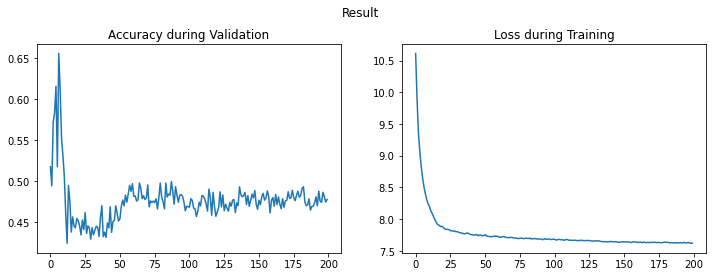

In [11]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

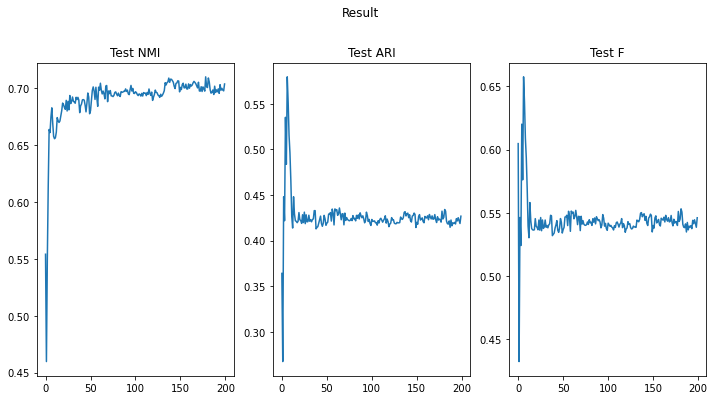

In [12]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
ax[0].plot(nmis)
ax[0].set_title('Test NMI')
ax[1].plot(aris)
ax[1].set_title('Test ARI')
ax[2].plot(fs)
ax[2].set_title('Test F')


plt.subplots_adjust(top=0.85)
plt.suptitle('Result')
plt.show()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

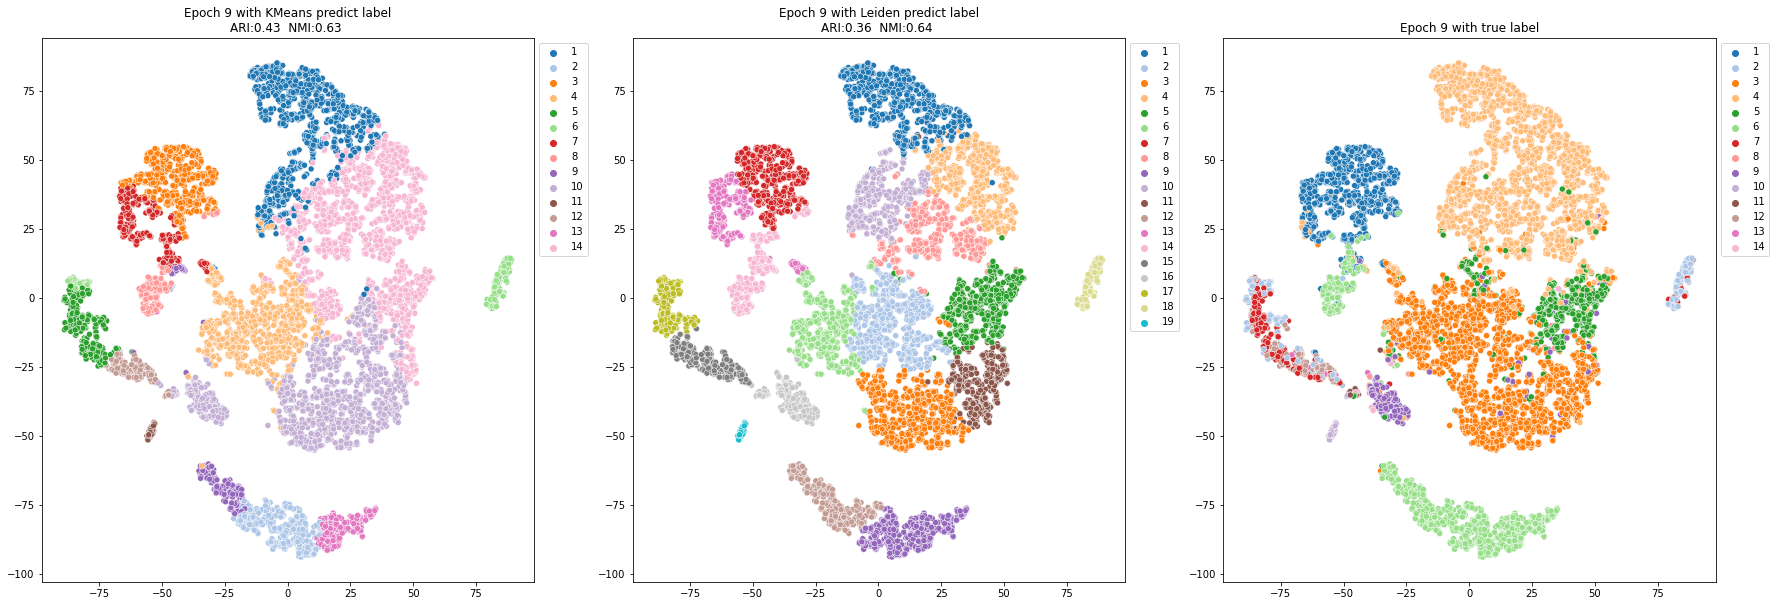

In [14]:
from evaluation import evaluation_tools
from sklearn.manifold import TSNE

mlp_1 = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlp_1, args.feature_dim, args.classnum)
model = model.to('cuda')

checkpoint = torch.load('save\sc-static-bank-500genes\checkpoint_9.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=9)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

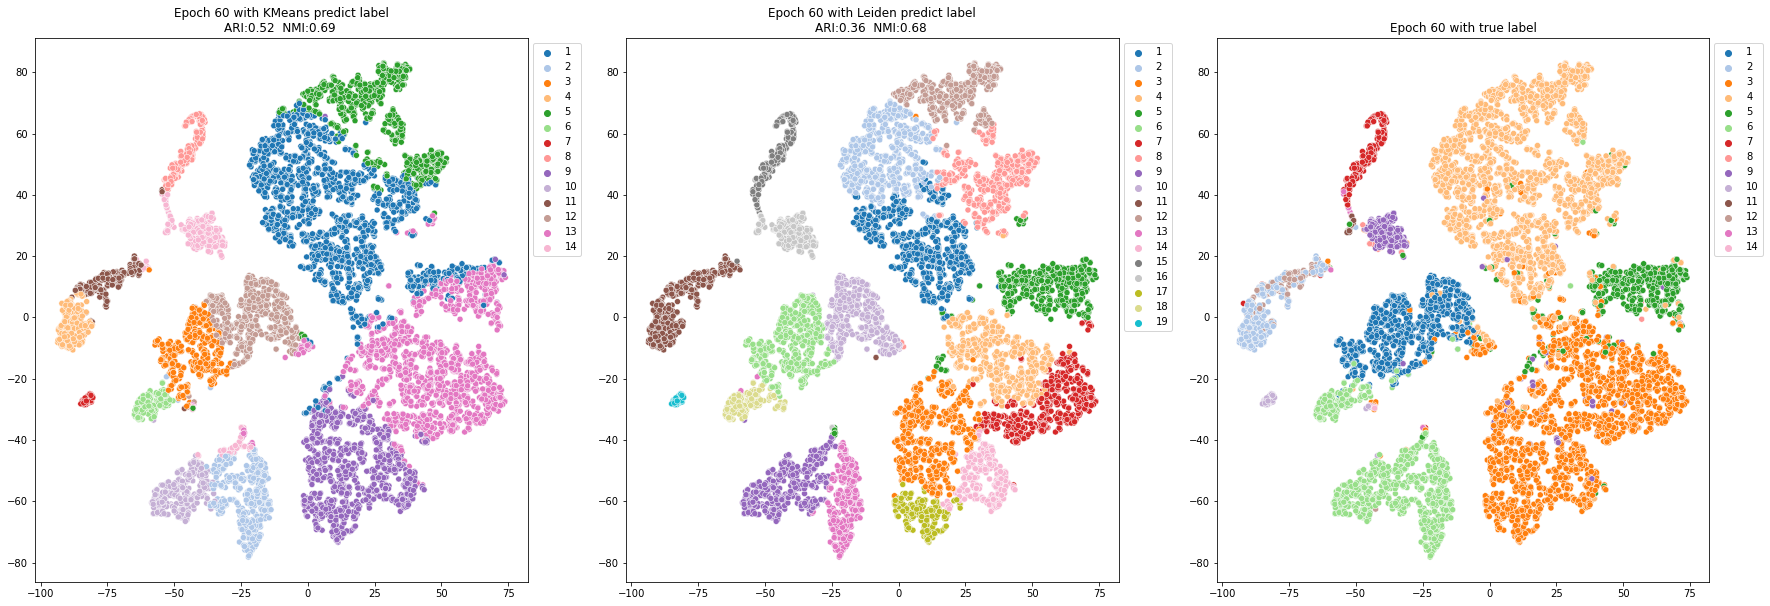

In [15]:
checkpoint = torch.load('save\sc-static-bank-500genes\checkpoint_60.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=60)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

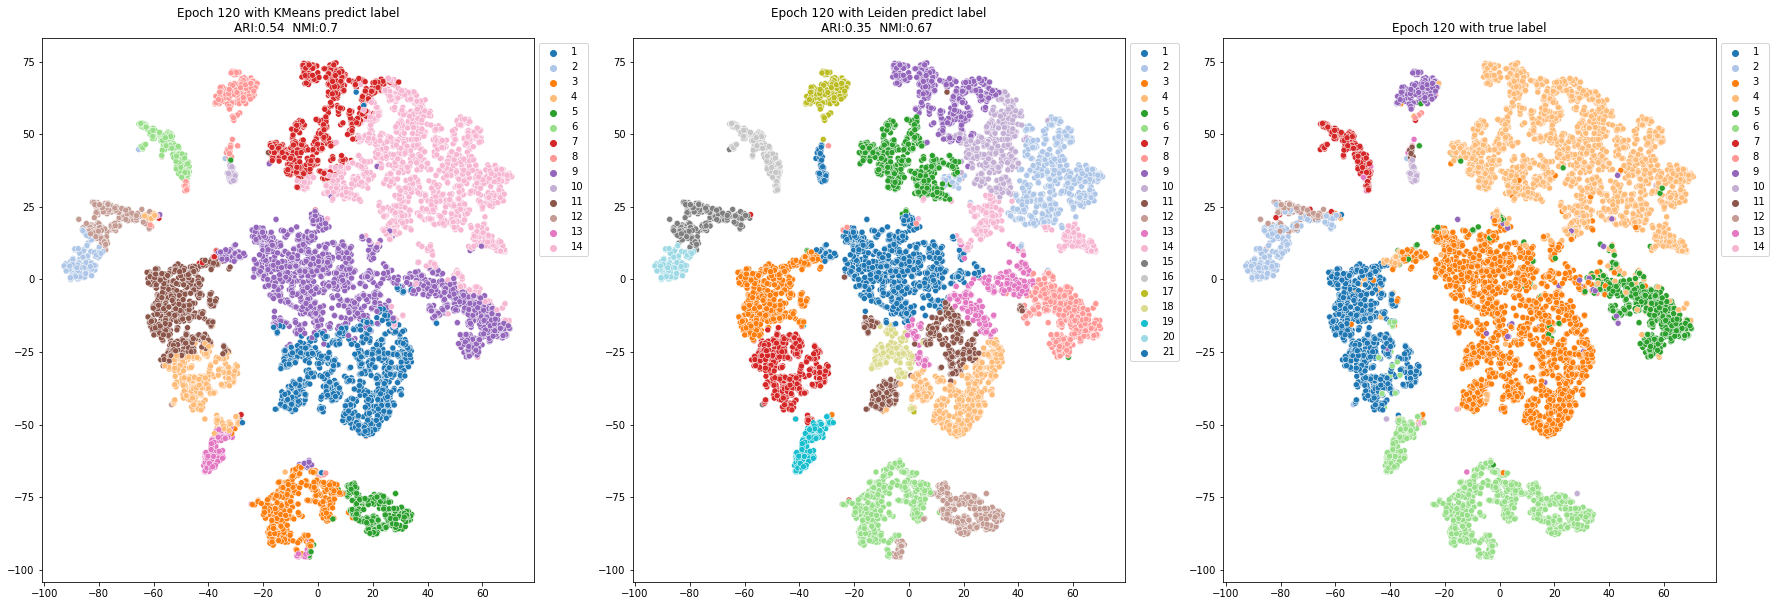

In [16]:
checkpoint = torch.load('save\sc-static-bank-500genes\checkpoint_120.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=120)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

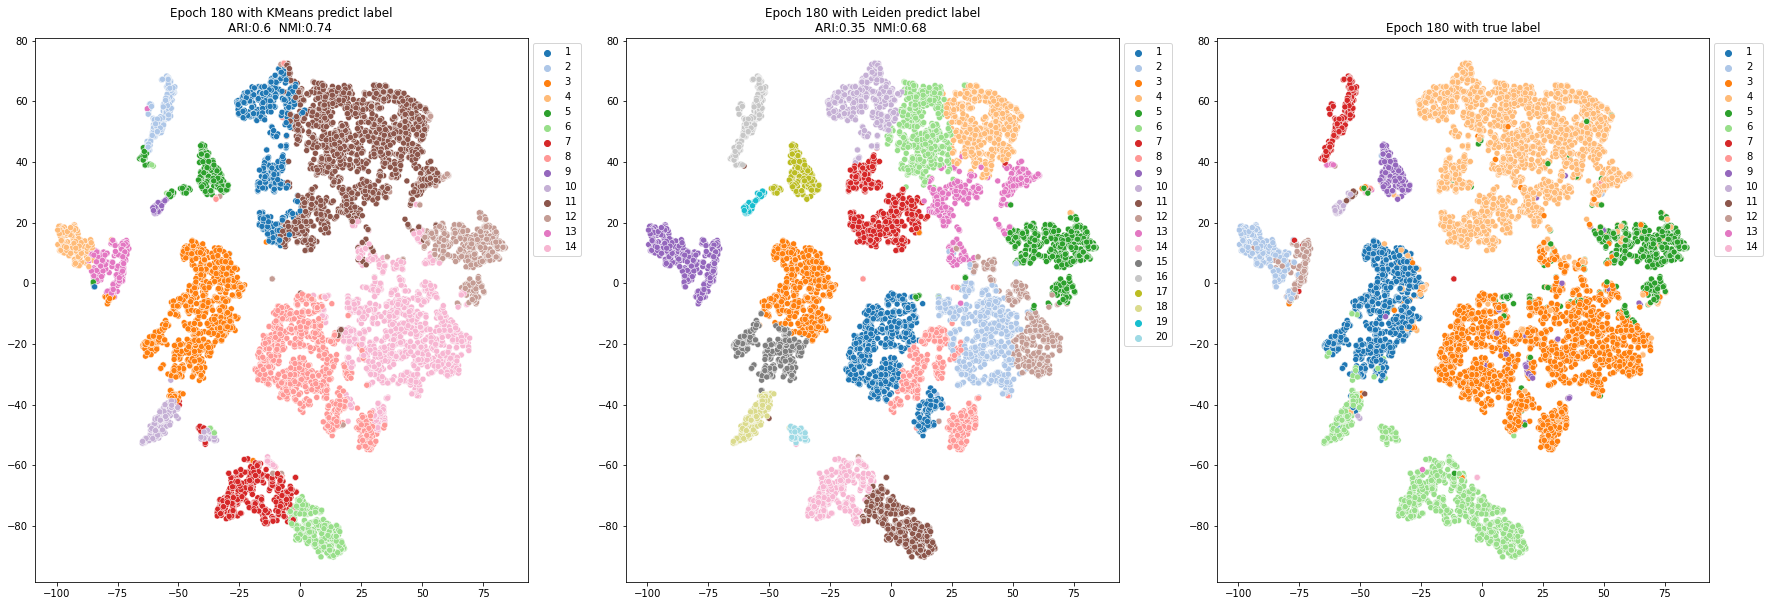

In [17]:
checkpoint = torch.load('save\sc-static-bank-500genes\checkpoint_180.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword 

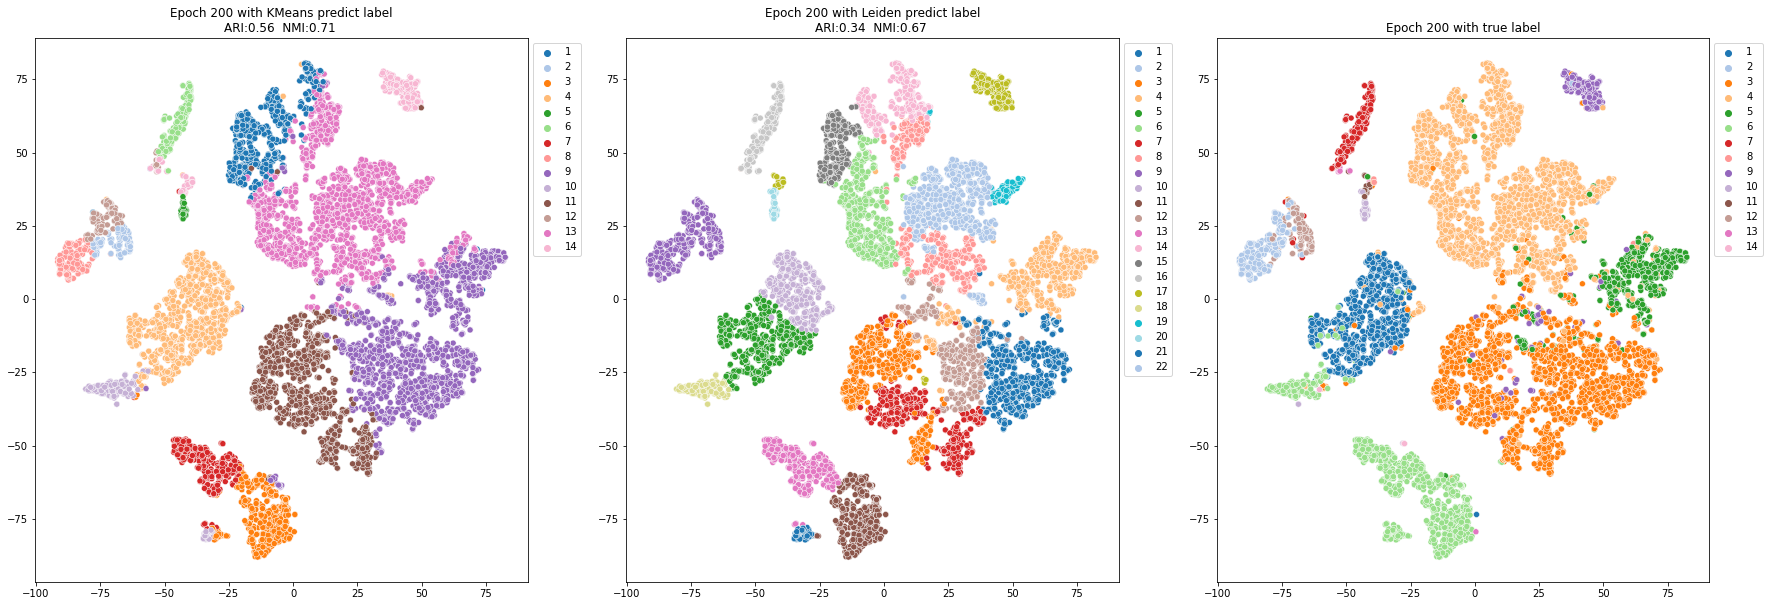

In [18]:
checkpoint = torch.load('save\sc-static-bank-500genes\checkpoint_200.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=200)